# Imports

In [1]:
%load_ext autoreload
%autoreload 2

print("Loading imports...")
from config import *

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data analysis
import glob
import os
import sys
from datetime import datetime, timedelta
import copy
import cftime

# Plotting
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.signal as signal
from scipy.stats import t
import xarray as xr
xr.set_options(keep_attrs=True)
import xrft

# Cartopy
from cartopy import crs as ccrs
from cartopy import feature as cf
from cartopy import util as cutil
from matplotlib import colors as mcolors
from matplotlib import ticker as mticker
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from plotting_functions import *
from matplotlib.animation import FuncAnimation

# import colormaps as cmaps
sys.path.insert(0, "/glade/u/home/sressel/auxiliary_functions/")
import mjo_mean_state_diagnostics as mjo
from bmh_colors import bmh_colors
from one_two_one_filter import one_two_one_filter
from rounding_functions import round_out
from tick_labeller import tick_labeller
from load_aquaplanet_data import *
from standardize_data import standardize_data
from processing_functions import *

print("Imports loaded")

Loading imports...
Imports loaded


# Specify analysis parameters

In [9]:
# Set latitude bounds
LATITUDE_SOUTH = -30
LATITUDE_NORTH = 30
latitude_subset_bounds = slice(LATITUDE_SOUTH, LATITUDE_NORTH)

# Set central longitude
CENTRAL_LONGITUDE = 0

# Set longitude bounds
LONGITUDE_MIN = 0
LONGITUDE_MAX = 360

# Set time bounds
missing_days = [
    cftime.DatetimeNoLeap(7, 2, 5, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(7, 2, 6, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(7, 2, 7, 0, 0, 0, 0, has_year_zero=True),
]

START_TIME = cftime.DatetimeNoLeap(3, 1, 3, 0, 0, 0, 0, has_year_zero=True)
END_TIME = cftime.DatetimeNoLeap(13, 1, 3, 0, 0, 0, 0, has_year_zero=True)
first_half_subset_bounds = slice(START_TIME, missing_days[0] - timedelta(days=1))
second_half_subset_bounds = slice(missing_days[-1] + timedelta(days=1), END_TIME)

# Cut-off periods for intraseasonal filtering
INTRASEASONAL_LOWCUT = 100
INTRASEASONAL_HIGHCUT = 20
frequency_subset_bounds = slice(INTRASEASONAL_LOWCUT, INTRASEASONAL_HIGHCUT)

# Cut-off wavenumbers for MJO-filtering
LARGE_SCALE_CUTOFF = 1
SMALL_SCALE_CUTOFF = 3
wavenumber_bounds = slice(LARGE_SCALE_CUTOFF, SMALL_SCALE_CUTOFF)

# Column-integrated bounds
LOWER_LEVEL_PRESSURE = 950
UPPER_LEVEL_PRESSURE = 100
pressure_subset_bounds = slice(UPPER_LEVEL_PRESSURE, LOWER_LEVEL_PRESSURE)

# Load data

In [10]:
reload_variables = False

variables_to_load = [
    "Precipitation",
    # "Outgoing Longwave Radiation",
    # "Zonal Wind",
    # "Meridional Wind",
    # "Vertical Wind",
    # "Temperature",
    # "Moisture",
    # "Relative Humidity",
    # "Geopotential Height",
    # "Longwave Heating Rate",
    # "Shortwave Heating Rate",
    # "Latent Heat Flux",
    # "Sensible Heat Flux",
    # "Surface Pressure",
    "Moist Static Energy",
    "Dry Static Energy",
    # "Column Moist Static Energy",
    # "Column Water Vapor",
    # "Column Temperature",
    # "Column Longwave Heating",
    # "Column Shortwave Heating"
    # "Potential Temperature",
    # "Saturation Specific Humidity"
    "Column Relative Humidity",
    # "Diabatic Heating"
]

# Process data

The data has to be subset in two halves, because there are three days without data in the middle of the dataset

## Load existing processed data

### Subset data

In [11]:
if not 'multi_experiment_variables_subset' in locals():
    multi_experiment_variables_subset = load_multi_experiment_subset_data(
        variables_to_load,
        {},
        False
    )
else:
    multi_experiment_variables_subset = load_multi_experiment_subset_data(
        variables_to_load,
        multi_experiment_variables_subset,
        False
    )

          Loading subset data           
(1/4) Precipitation...                  
----------------------------------------
Variable already loaded
(2/4) Moist Static Energy...            
----------------------------------------
Variable already loaded
(3/4) Dry Static Energy...              
----------------------------------------
Loading data...
    Experiment: -4K                    ✔
    Experiment: 0K                     ✔
    Experiment: 4K                     ✔
Concatenating data...                  ✔
(4/4) Column Relative Humidity...       
----------------------------------------
Variable already loaded
Finished


## Column Relative Humidity

In [12]:
print(f"{f'Average over CRH bins':^{str_width}}")
print(f"{'='*str_width}")

CRH = multi_experiment_variables_subset['Column Relative Humidity']

reload_bins = True
if not 'variable_mean_over_CRH' in globals() or reload_bins:
    variable_mean_over_CRH = {}

CRH_binned = {}
fitting_indices = {}
best_fit_line = {}
bin_indices = {}

binning_latitudes = slice(-15,15)

variables_to_bin = [
    multi_experiment_variables_subset['Precipitation'],
    # multi_experiment_variables_subset['Temperature'],
    # multi_experiment_variables_subset['Vertical Wind'],
    multi_experiment_variables_subset['Moist Static Energy'],
    multi_experiment_variables_subset['Dry Static Energy'],
    # alpha
]

bins = np.arange(round_out(CRH.min().values, 2), round_out(CRH.max().values, 2), 0.01)
bins = np.array([np.around(bin, 2) for bin in bins])
bin_centers = np.array([(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)])

reference_precipitation = xr.DataArray(
    data = np.empty((len(experiments_list))),
    dims = ['experiment'],
    coords = {
        'experiment': experiments_list
    }
)
reference_slope_parameter = xr.DataArray(
    data = np.empty((len(experiments_list))),
    dims = ['experiment'],
    coords = {
        'experiment': experiments_list
    }
)

# for experiment in ['-4K', '0K', '4K']:

#     # Find the correct bin for each CRH value
#     bin_indices[experiment] = np.digitize(flattened_CRH_data, bins)

#     CRH_binned[experiment] = [
#             len(flattened_CRH_data[bin_indices[experiment] == i]) for i in range(1, len(bins))
#         ]

for index, variable_data in enumerate(variables_to_bin):
    variable_name = variable_data.name
    print(f"{'-'*str_width}")
    print(f"{f'({index+1}/{len(variables_to_bin)}) {variable_name}...':<{str_width}}")

    variable_mean_over_CRH[variable_name] = xr.DataArray(
        data=np.empty(
            (3, len(bin_centers),)
            + (
                (len(variable_data.plev),)
                if "plev" in variable_data.dims
                else ()
            )
        ),
        dims=["experiment", "CRH"] + (["plev"] if "plev" in variable_data.dims else []),
        coords={
            "experiment": experiments_array,
            "CRH": bin_centers,
            **({"plev": variable_data.plev} if "plev" in variable_data.dims else {})
        },
        name=variable_data.name,
        attrs=variable_data.attrs
)

    for experiment_index, experiment in enumerate(['-4K', '0K', '4K']):
        print(f"{f'    Experiment: {experiment}...':<{str_width-1}}", end="")

        # Flatten the (time, lat, lon) CRH & precipitation data for a given experiment
        flattened_CRH_data = CRH.sel(
            experiment=experiment, lat=binning_latitudes
        ).values.flatten()

        if 'plev' in variable_data.coords:
            print("")
            for plev_index, plev in enumerate(variable_data.plev):
                if (plev_index+1)%10 == 0:
                    print(f"{f'        plev: {plev.values}...':<{str_width-1}}", end="")

                flattened_variable_data = variable_data.sel(
                        experiment=experiment, lat=binning_latitudes, plev=plev
                    ).values.flatten()

                # # Bin precipitation by CRH
                # variable_binned_by_CRH = [
                #     flattened_variable_data[bin_indices[experiment] == i] for i in range(1, len(bins))
                # ]

                # # Average the precipitation in each CRH bin
                # variable_mean_over_CRH[variable_name][experiment_index, :, plev_index] = np.array(
                #     [np.mean(bin) if bin.size > 0 else np.nan for bin in variable_binned_by_CRH]
                # )
                variable_mean_over_CRH[variable_name][experiment_index, :, plev_index] = sp.stats.binned_statistic(
                    x=flattened_CRH_data,
                    values=flattened_variable_data,
                    statistic='mean',
                    bins=bins
                ).statistic

                if (plev_index+1)%10 == 0:
                    print(rf"{'✔':>1}")

        else:
            flattened_variable_data = variable_data.sel(
                    experiment=experiment, lat=binning_latitudes
                ).values.flatten()

            # # Bin precipitation by CRH
            # variable_binned_by_CRH = [
            #     flattened_variable_data[bin_indices[experiment] == i] for i in range(1, len(bins))
            # ]

            # # Average the precipitation in each CRH bin
            # variable_mean_over_CRH[variable_name][experiment_index][:] = np.array(
            #     [np.mean(bin) if bin.size > 0 else np.nan for bin in variable_binned_by_CRH]
            # )
            variable_mean_over_CRH[variable_name][experiment_index, :] = sp.stats.binned_statistic(
                x=flattened_CRH_data,
                values=flattened_variable_data,
                statistic='mean',
                bins=bins
            ).statistic

            print(rf"{'✔':>1}")

print(f"{'='*str_width}")
print("Finished")

         Average over CRH bins          
----------------------------------------
(1/3) Precipitation...                  
    Experiment: -4K...                 ✔
    Experiment: 0K...                  ✔
    Experiment: 4K...                  ✔
----------------------------------------
(2/3) Moist Static Energy...            
    Experiment: -4K...                 
        plev: 250...                   ✔
        plev: 500...                   ✔
        plev: 750...                   ✔
        plev: 1000...                  ✔
    Experiment: 0K...                  
        plev: 250...                   ✔
        plev: 500...                   ✔
        plev: 750...                   ✔
        plev: 1000...                  ✔
    Experiment: 4K...                  
        plev: 250...                   ✔
        plev: 500...                   ✔
        plev: 750...                   ✔
        plev: 1000...                  ✔
----------------------------------------
(3/3) Dry Static En

## Chikira alpha parameter

In [10]:
print(f"{'Calculating Alpha ...':<{str_width-1}}", end="")
exner_function = (multi_experiment_variables_subset['Moisture'].plev/1000)**(DRY_AIR_GAS_CONSTANT/SPECIFIC_HEAT)

compute_full_alpha = False
if compute_full_alpha:
    alpha = (
        - (HEAT_OF_VAPORIZATION/SPECIFIC_HEAT/exner_function)
        * (0.01*multi_experiment_variables_subset['Moisture'].differentiate('plev'))
        / (0.01*multi_experiment_variables_subset['Potential Temperature'].differentiate('plev'))
    )

alpha_by_CRH = xr.zeros_like(variable_mean_over_CRH['Moisture'])
alpha_by_CRH[:] = -(HEAT_OF_VAPORIZATION/SPECIFIC_HEAT/exner_function.values)*np.einsum(
    'ijk, ijk -> ijk',
    (0.01*variable_mean_over_CRH['Moisture'].differentiate('plev')).values,
    1/(0.01*variable_mean_over_CRH['Potential Temperature'].differentiate('plev')).values
)
print(rf"{'✔':>1}")
alpha_by_CRH.name = 'Chikira alpha'
alpha_by_CRH.attrs['units'] = ''
alpha_by_CRH.attrs['short_name'] = 'Chikira α'
alpha_by_CRH.attrs['file_id'] = 'chikira_alpha'

# plot_vertical_profile(alpha, lat_bounds=slice(-30,30), zero_bounded = True)

print(f"{'='*str_width}")
print("Finished")

Calculating Alpha ...                  ✔
Finished


In [24]:
variable_mean_over_CRH['Chikira alpha'] = alpha_by_CRH

In [19]:
def plot_vertical_profile(variable_to_plot, lat_bounds=slice(-10,10), zero_bounded=False):

    if 'lat' in variable_to_plot.coords:
        experiment_mean_variable_to_plot = variable_to_plot.sel(lat=lat_bounds).mean(dim=['time', 'lat', 'lon'])
    else:
        experiment_mean_variable_to_plot = variable_to_plot

    plt.style.use('bmh')
    plt.rcParams.update(
        {
        'font.size':14,
        'mathtext.fontset':'dejavusans'
        }
    )
    [fig, ax] = plt.subplots(1, 1, figsize=(4.5,9))

    ax.set_title(f"Experiment-mean {variable_to_plot.attrs['short_name']} \nVertical Profile ", pad=10)
    for experiment in experiments_array.coords['experiment']:
        ax.plot(
            experiment_mean_variable_to_plot.sel(experiment=experiment),
            experiment_mean_variable_to_plot.plev,
            label=experiments_array.sel(experiment=experiment)['name'].item(),
        )

    ax.set_xlabel(f"{experiment_mean_variable_to_plot.attrs['units']}")
    ax.set_ylabel('hPa')
    ax.legend(loc='lower left')

    if zero_bounded == True:
        if np.all(experiment_mean_variable_to_plot.values) >= 0:
            ax.set_xlim(left=0)
        elif np.all(experiment_mean_variable_to_plot.values) <= 0:
            ax.set_xlim(right=0)
        else:
            print("Data not single-signed")

    ax.set_yticks(np.arange(0, 1100, 100))
    ax.set_ylim(100, 1000)
    ax.invert_yaxis()
    for side in ['top', 'bottom', 'left', 'right']:
        ax.spines[side].set(lw=2)
        ax.spines[side].set(color="#bcbcbc")

    plt.show()

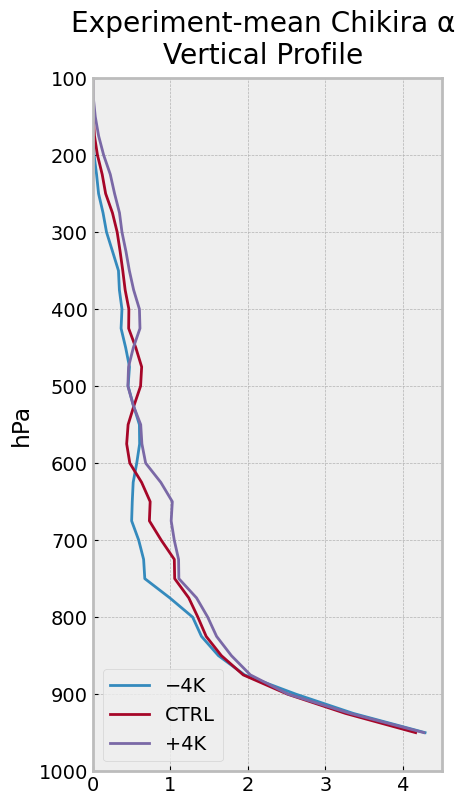

In [22]:
experiment_mean_alpha_profile = alpha_by_CRH.weighted(alpha_by_CRH.CRH).sum('CRH')/alpha_by_CRH.CRH.sum('CRH')
plot_vertical_profile(
    experiment_mean_alpha_profile.sel(plev=slice(100, 950)), (-30,30), zero_bounded=True)

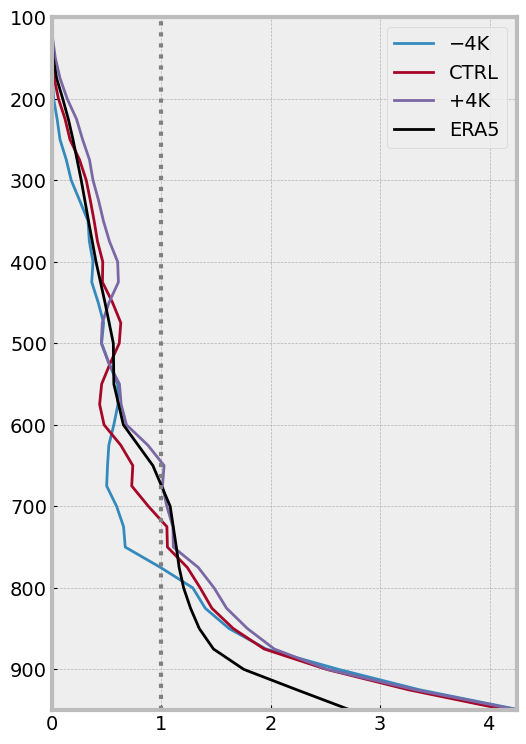

In [39]:
# ERA5_temperature = xr.open_dataarray("/glade/campaign/univ/uwas0152/post_processed_data/ERA5_vertical_temperature_profile.nc")

plt.style.use('bmh')
plt.rcParams.update({'font.size':14})
[fig, ax] = plt.subplots(1, 1, figsize=(6,9))

axes[0].set_title('alpha')
for experiment in experiments_array.coords['experiment']:
    ax.plot(
        experiment_mean_alpha_profile.sel(experiment=experiment),
        experiment_mean_alpha_profile.plev,
        label=experiments_array.sel(experiment=experiment)['name'].item(),
    )

ax.plot(
    ERA5_alpha,
    ERA5_alpha.plev,
    label="ERA5",
    color='k'
)
ax.axvline(x=1, ls=':', lw=3, color='gray')

ax.legend(loc='upper right')
ax.set_xlim(0, 4.25)
ax.set_yticks(np.arange(100, 950, 100))
ax.set_ylim(100, 950)
ax.set_ylabel('hPa')
ax.invert_yaxis()

for axis in ['top', 'left', 'right', 'bottom']:
    ax.spines[axis].set(lw=3)
    ax.spines[axis].set(color='#bcbcbc')

plt.show()

In [31]:
ERA5_alpha = xr.DataArray(
    data = np.array([6.23267750e-04, 1.79818661e-03, 1.09971449e-02, 4.24795830e-02,
       9.79972165e-02, 1.49275662e-01, 1.91756118e-01, 2.67197248e-01,
       3.33823989e-01, 4.02337663e-01, 4.84426501e-01, 5.60644546e-01,
       5.65533167e-01, 6.52350947e-01, 9.21976606e-01, 1.08030390e+00,
       1.13649542e+00, 1.16222445e+00, 1.20322503e+00, 1.26632870e+00,
       1.34657772e+00, 1.47592517e+00, 1.75309305e+00, 2.23696279e+00,
       2.72989205e+00, 3.54708033e+00, 7.20756780e+00]),
    dims=['plev'],
    coords={'plev':np.array([ 100.,  125.,  150.,  175.,  200.,  225.,  250.,  300.,  350.,  400.,
        450.,  500.,  550.,  600.,  650.,  700.,  750.,  775.,  800.,  825.,
        850.,  875.,  900.,  925.,  950.,  975., 1000.])}
)

In [37]:
ERA5_data_directory = "/glade/campaign/univ/uwas0152/post_processed_data/"
ERA5_variables_by_CRH = xr.open_dataset(f"{ERA5_data_directory}/ERA5_variables_by_CRH.nc")
ERA5_alpha_by_CRH = xr.open_dataset(f"{ERA5_data_directory}/ERA5_variables_by_CRH.nc")['Chikira alpha']
ERA5_precipitation_by_CRH = xr.open_dataset(f"{ERA5_data_directory}/ERA5_variables_by_CRH.nc")['Precipitation']
ERA5_potential_temperature_by_CRH = xr.open_dataset(f"{ERA5_data_directory}/ERA5_variables_by_CRH.nc")['Potential Temperature']
ERA5_DSE_by_CRH = xr.open_dataset(f"{ERA5_data_directory}/ERA5_dry_static_energy_by_CRH.nc")['Dry Static Energy']
ERA5_MSE_by_CRH = xr.open_dataset(f"{ERA5_data_directory}/ERA5_moist_static_energy_by_CRH.nc")['Moist Static Energy']

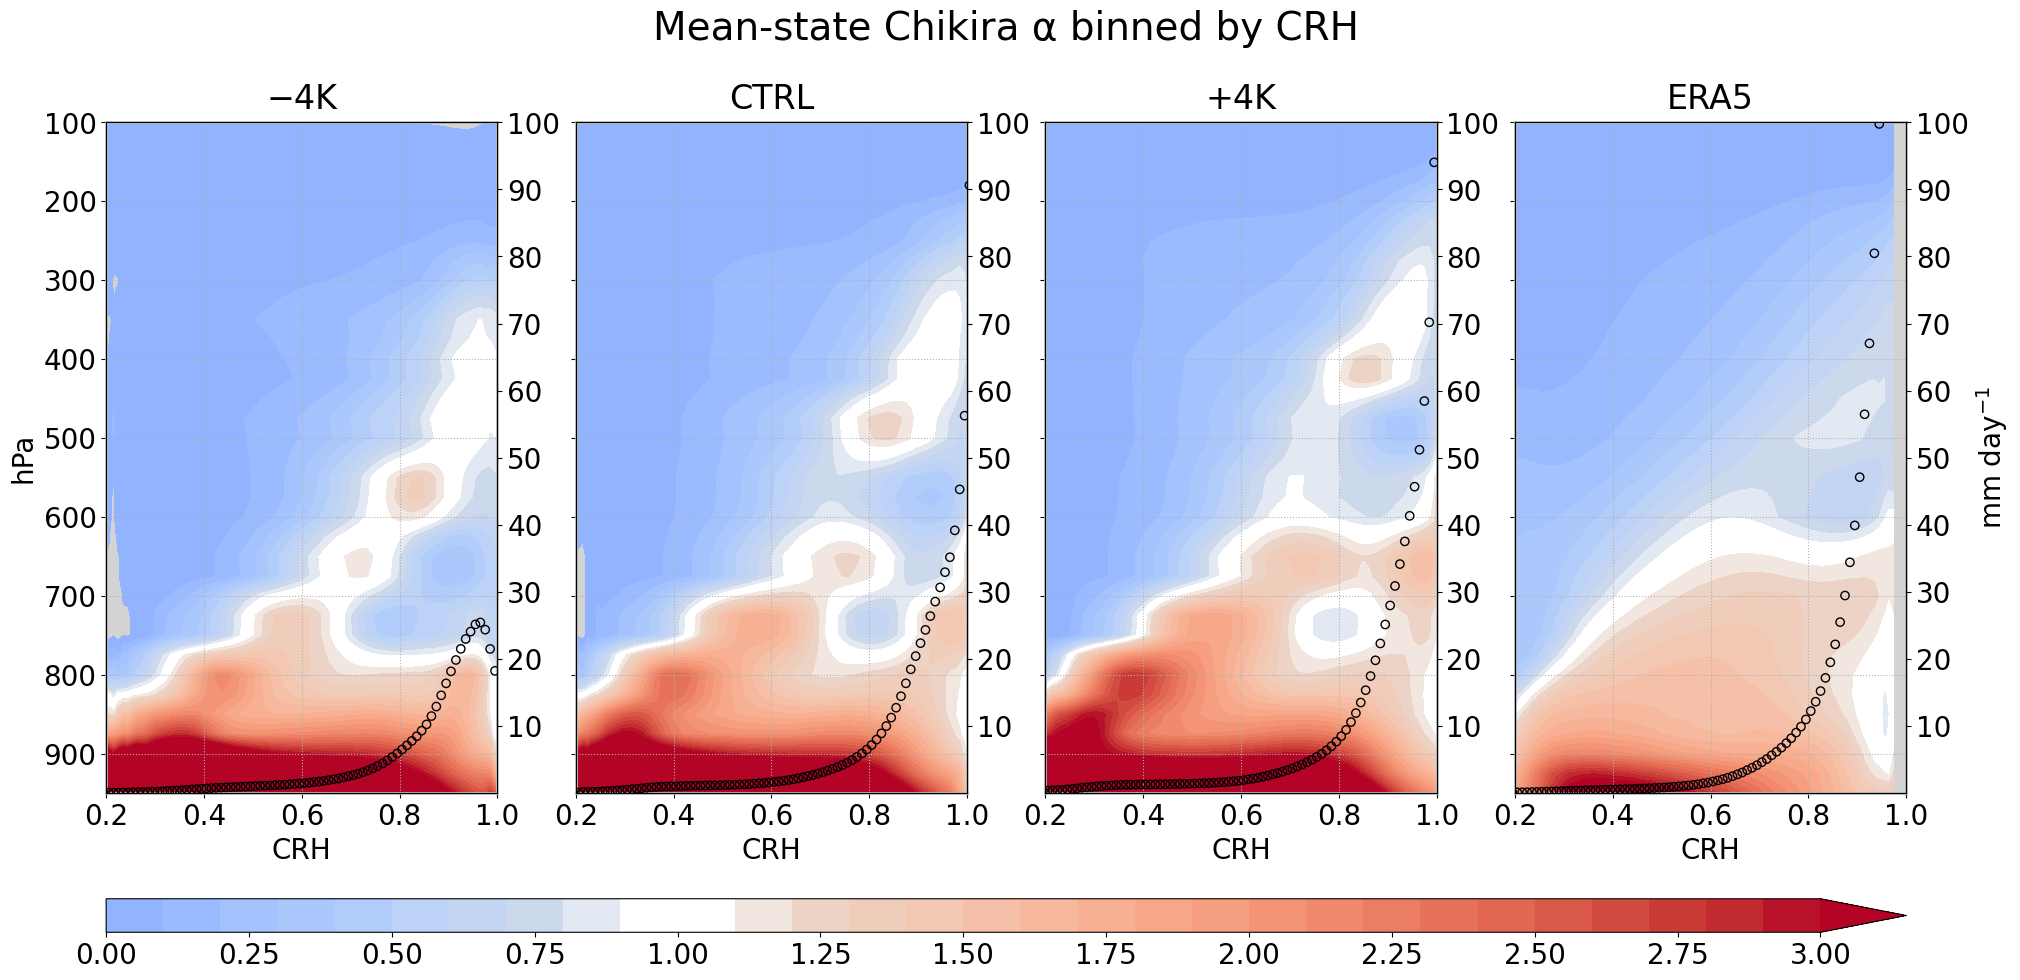

In [13]:
savefig = False
variable_to_plot = 'alpha'

variable_mean_over_CRH['alpha'] = alpha_by_CRH
plt.rcParams.update({'font.size':20, 'mathtext.fontset':'dejavusans'})

fig = plt.figure(figsize=(20,9))
# gs = GridSpec(1, 5, figure=fig, width_ratios=[30,30,30,30,2])
# gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, wspace=0.25)

gs = GridSpec(2, 4, figure=fig, height_ratios=[20,1])
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, wspace=0.2, hspace=0.3)

axes = []
grand_min = variable_mean_over_CRH[variable_to_plot].min()
grand_max = variable_mean_over_CRH[variable_to_plot].max()

cbar_ax = fig.add_subplot(gs[-1, :])
pr_ax = []

for index, experiment in enumerate(experiments_list):
    axes.append(fig.add_subplot(gs[0, index]))
    axes[index].set_title(experiments_array.sel(experiment=experiment)['name'].item(), fontsize=24, pad=10)
    im = axes[index].contourf(
        variable_mean_over_CRH[variable_to_plot].CRH,
        variable_mean_over_CRH[variable_to_plot].plev,
        variable_mean_over_CRH[variable_to_plot].sel(experiment=experiment).T,
        levels=np.arange(0, 3+0.1, 0.1),
        cmap=mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05),
        norm=mcolors.CenteredNorm(vcenter=1),
        extend='max'
    )
    # axes[index].yaxis.grid()
    axes[index].grid(True, ls=':')

    ax2 = plt.twinx()
    ax2.scatter(
        variable_mean_over_CRH['Precipitation'].CRH,
        variable_mean_over_CRH['Precipitation'].sel(experiment=experiment),
        label=experiment,
        # edgecolors=bmh_colors(index+1),
        edgecolors='k',
        facecolors='none',
        lw=1,
    )
    ax2.set_ylim(0, 100)
    ax2.set_yticks(np.arange(10,110,10))
    ax2.grid(False)
    # ax2.set_ylabel(r'mm day$^{-1}$')

#### Add ERA5 Alpha & Precipitation
axes.append(fig.add_subplot(gs[index+1]))
axes[index+1].set_title("ERA5", fontsize=24, pad=10)
axes[index+1].contourf(
    ERA5_alpha_by_CRH.CRH,
    ERA5_alpha_by_CRH.plev,
    ERA5_alpha_by_CRH.T,
    levels=np.arange(0, 3+0.1, 0.1),
    cmap=mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05),
    norm=mcolors.CenteredNorm(vcenter=1),
    extend='max'
)
# axes[index+1].yaxis.grid()
axes[index+1].grid(True, ls=':')

ax2 = axes[index+1].twinx()
ax2.scatter(
    ERA5_precipitation_by_CRH.CRH,
    SECONDS_PER_DAY*ERA5_precipitation_by_CRH,
    edgecolors='k',
    facecolors='none',
    lw=1,
    zorder=10
)
ax2.set_ylim(0, 100)
ax2.set_yticks(np.arange(10,110,10))
ax2.set_ylabel(r'mm day$^{-1}$')
ax2.grid(False)

cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label(variable_mean_over_CRH[variable_to_plot].attrs['units'])
cbar.set_ticks(np.arange(0, 3.25, 0.25))

fig.suptitle(
    f"Mean-state {variable_mean_over_CRH[variable_to_plot].attrs['short_name']} binned by CRH",
    x=(axes[0].get_position().x0 + axes[index+1].get_position().x1)/2,
    ha='center',
    y=1.075,
    size=28
)

for index, ax in enumerate(axes):

    ax.set_facecolor('lightgrey')
    for edge in ["top", "bottom", "left", "right"]:
        ax.spines[edge].set_linewidth(2)
        ax.spines[edge].set_color("#bcbcbc")
    ax.set_xlabel('CRH')
    ax.set_xlim(0.2, 1)
    ax.set_xticks(np.arange(0.2, 1.2, 0.2))
    # ax.xaxis.set_major_locator(mticker.MaxNLocator(6, prune="lower"))
    if index == 0:
        ax.set_ylabel('hPa')
        ax.set_yticks(np.arange(100, 1100, 100))
    else:
        ax.set_yticks(np.arange(100, 1100, 100), labels=[])
    ax.set_ylim(100, 950)
    ax.invert_yaxis()

if not savefig:
    plt.show()
else:
    save_string = (
        f"multi-experiment_{variable_mean_over_CRH[variable_to_plot].attrs['file_id']}.png"
        )
    print(f"Saving plot as {save_string}")
    plt.savefig(
        f"{output_directory}/mean-state/variables_binned_by_CRH/{save_string}",
        dpi=500,
        bbox_inches="tight",
    )

# print(f"{'='*str_width}")
# print("Finished")

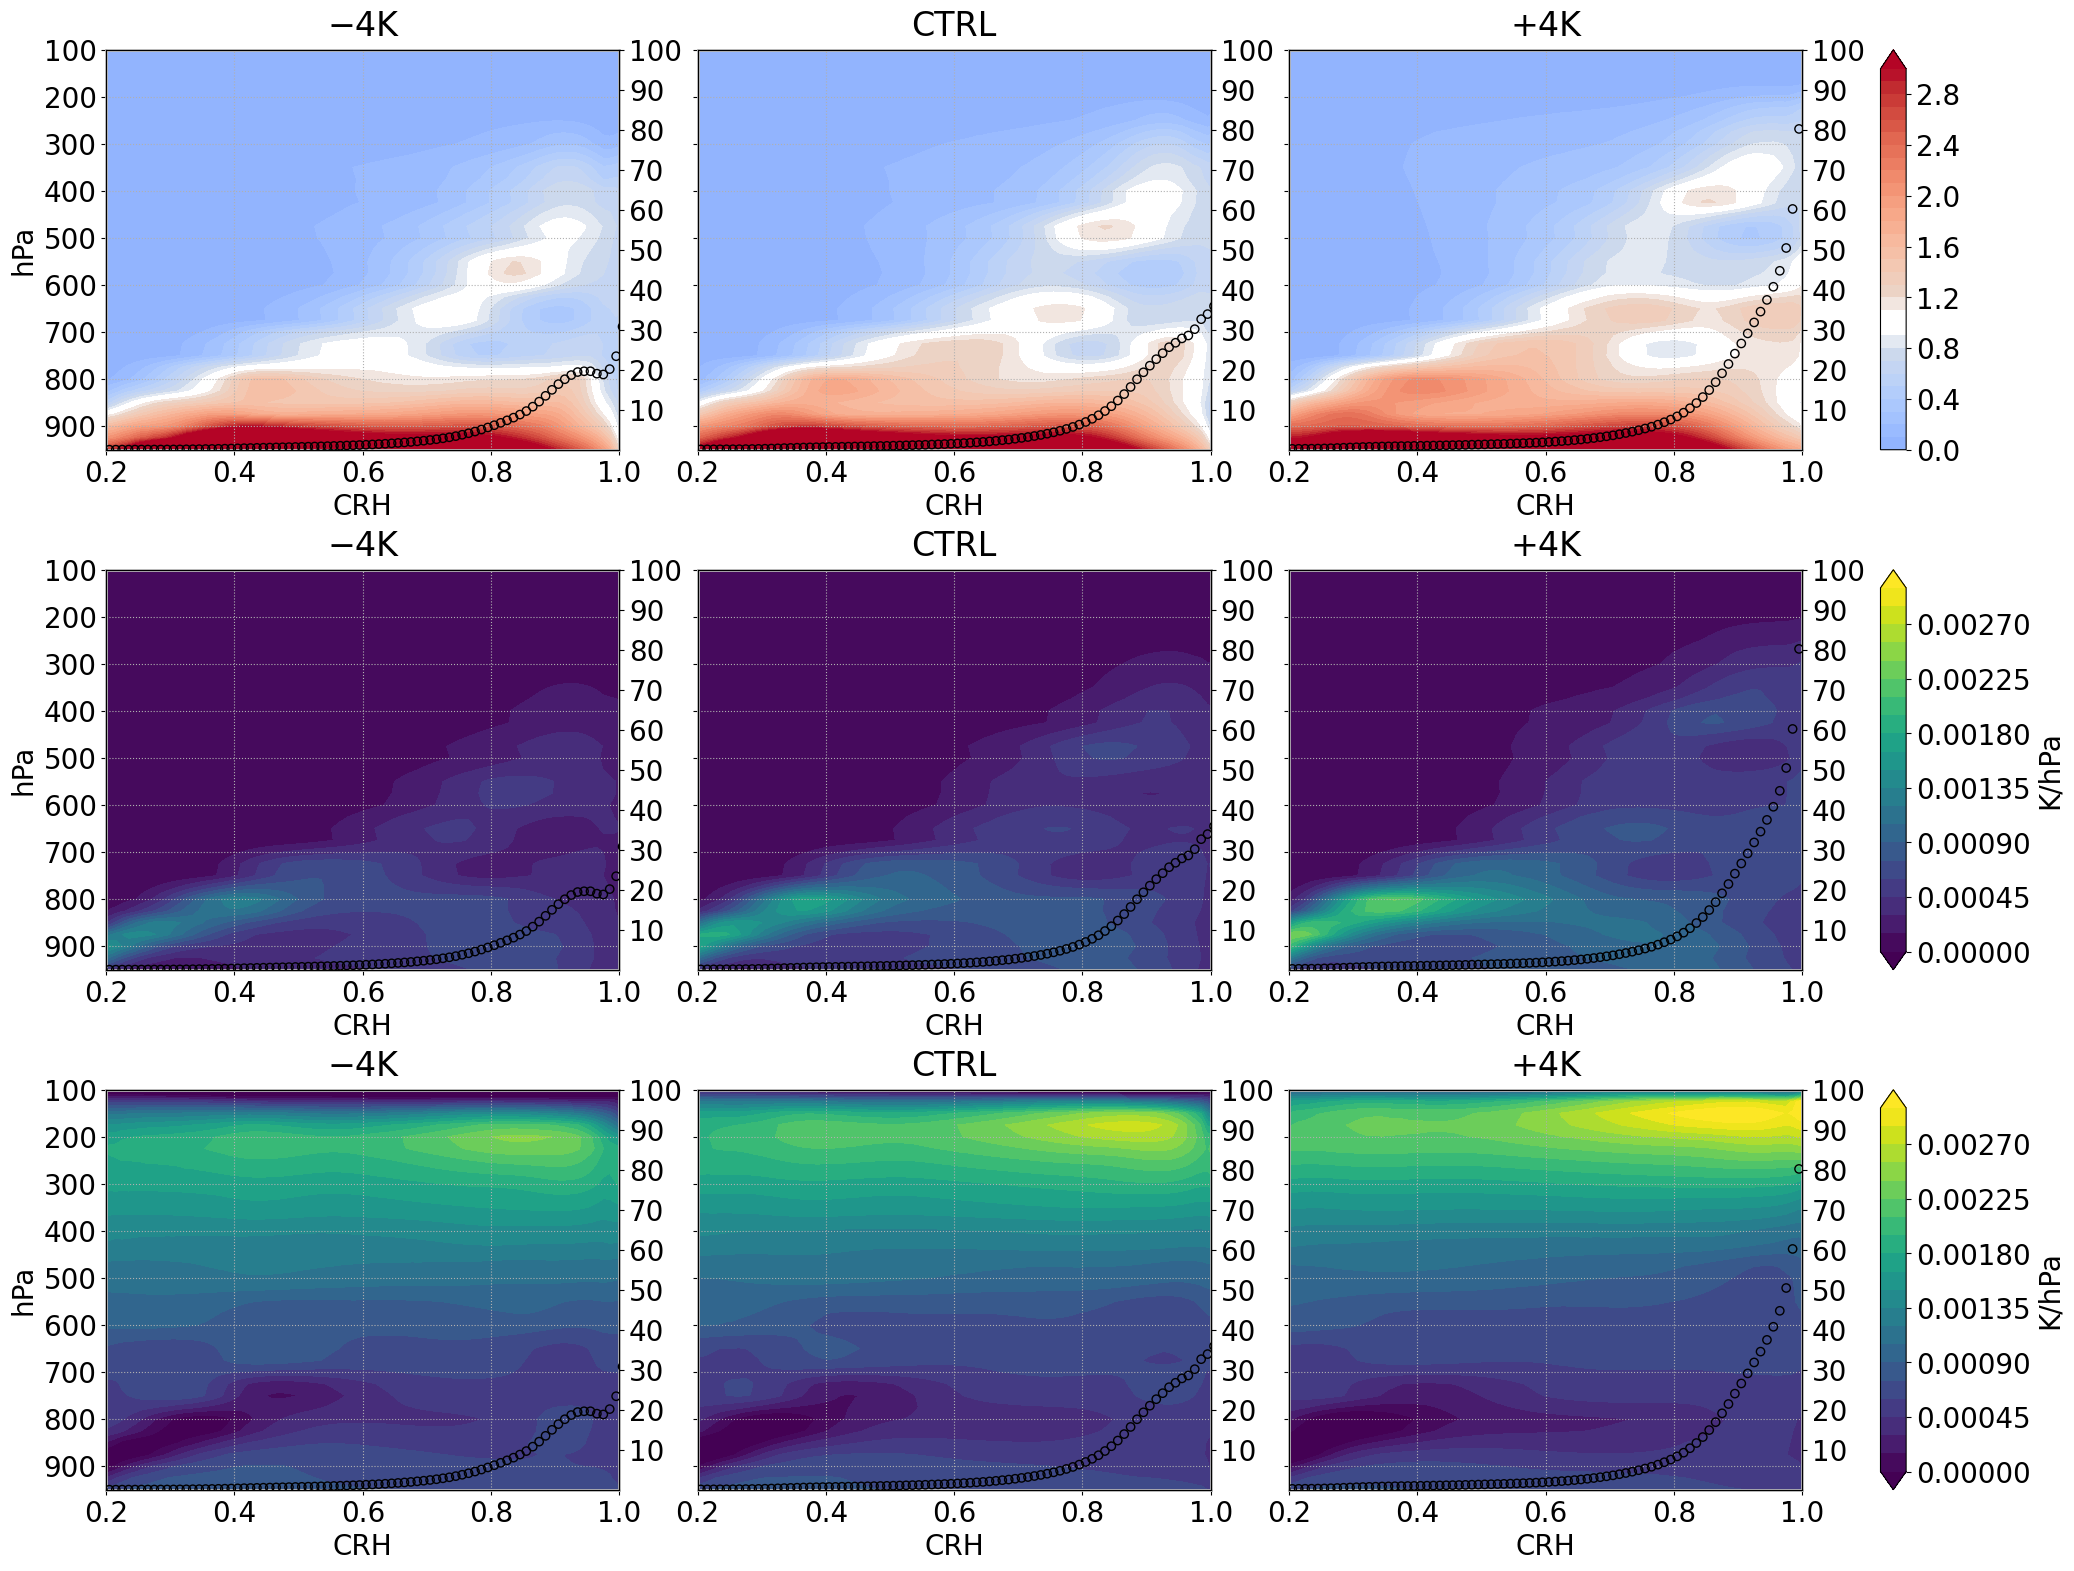

In [241]:
savefig = False
# variable_to_plot = 'alpha'

variable_mean_over_CRH['Chikira alpha'] = alpha_by_CRH
# variable_mean_over_CRH['Moisture'].name = 'Moisture'
# variable_mean_over_CRH['Moisture'].attrs = multi_experiment_variables_subset['Moisture'].attrs
# variable_mean_over_CRH['Potential Temperature'].attrs = multi_experiment_variables_subset['Potential Temperature'].attrs

# scaled_moisture = 0.01*(HEAT_OF_VAPORIZATION/SPECIFIC_HEAT)*variable_mean_over_CRH['Moisture'].differentiate('plev')
# scaled_moisture.attrs = variable_mean_over_CRH['Moisture'].attrs
# scaled_moisture.attrs['units'] = 'K/hPa'

# scaled_potential_temperature = 0.01*(variable_mean_over_CRH['Potential Temperature']*exner_function).differentiate('plev')
# scaled_potential_temperature.attrs = variable_mean_over_CRH['Potential Temperature'].attrs
# scaled_potential_temperature.attrs['units'] = 'K/hPa'

variables_to_plot = [
    variable_mean_over_CRH['alpha'],
    scaled_moisture,
    scaled_potential_temperature
]

colorbar_bounds = [
    np.arange(0, 3.1, 0.1),
    np.linspace(0, 0.003, 21),
    np.linspace(0, 0.003, 21),
]
plt.rcParams.update({'font.size':20, 'mathtext.fontset':'dejavusans'})

fig = plt.figure(figsize=(20,16))

gs = GridSpec(3, 4, figure=fig, width_ratios = [20, 20, 20, 1])
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, wspace=0.2, hspace=0.3)

for row_index, variable_data in enumerate(variables_to_plot):

    axes = []
    grand_min = variable_mean_over_CRH[variable_to_plot].min()
    grand_max = variable_mean_over_CRH[variable_to_plot].max()

    cbar_ax = fig.add_subplot(gs[row_index, -1])

    for column_index, experiment in enumerate(experiments_list):
        axes.append(fig.add_subplot(gs[row_index, column_index]))
        axes[column_index].set_title(experiments_array.sel(experiment=experiment)['name'].item(), fontsize=24, pad=10)
        im = axes[column_index].contourf(
            variable_data.CRH,
            variable_data.plev,
            variable_data.sel(experiment=experiment).T,
            # levels=np.arange(0, 3+0.1, 0.1),
            levels=colorbar_bounds[row_index],
            cmap=(mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05) if variable_data.name == 'Chikira alpha' else 'viridis'),
            norm=(mcolors.CenteredNorm(vcenter=1) if variable_data.name == 'Chikira alpha' else mcolors.Normalize()),
            extend=('max' if variable_data.name == 'Chikira alpha' else 'both')
        )
        # axes[index].yaxis.grid()
        axes[column_index].grid(True, ls=':')

        ax2 = plt.twinx()
        ax2.scatter(
            variable_mean_over_CRH['Precipitation'].CRH,
            variable_mean_over_CRH['Precipitation'].sel(experiment=experiment),
            label=experiment,
            # edgecolors=bmh_colors(index+1),
            edgecolors='k',
            facecolors='none',
            lw=1,
        )
        ax2.set_ylim(0, 100)
        ax2.set_yticks(np.arange(10,110,10))
        ax2.grid(False)
        # ax2.set_ylabel(r'mm day$^{-1}$')

    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label(variable_data.attrs['units'])
    # cbar.set_ticks(np.arange(0, 3.25, 0.25))

    # fig.suptitle(
    #     f"Mean-state {variable_data.attrs['short_name']} binned by CRH",
    #     x=(axes[0].get_position().x0 + axes[-1].get_position().x1)/2,
    #     ha='center',
    #     y=1.075,
    #     size=28
    # )

    for index, ax in enumerate(axes):

        ax.set_facecolor('lightgrey')
        for edge in ["top", "bottom", "left", "right"]:
            ax.spines[edge].set_linewidth(2)
            ax.spines[edge].set_color("#bcbcbc")
        ax.set_xlabel('CRH')
        ax.set_xlim(0.2, 1)
        ax.set_xticks(np.arange(0.2, 1.2, 0.2))
        # ax.xaxis.set_major_locator(mticker.MaxNLocator(6, prune="lower"))
        if index == 0:
            ax.set_ylabel('hPa')
            ax.set_yticks(np.arange(100, 1100, 100))
        else:
            ax.set_yticks(np.arange(100, 1100, 100), labels=[])
        ax.set_ylim(100, 950)
        ax.invert_yaxis()

if not savefig:
    plt.show()
else:
    save_string = (
        f"multi-experiment_{variable_mean_over_CRH[variable_to_plot].attrs['file_id']}.png"
        )
    print(f"Saving plot as {save_string}")
    plt.savefig(
        f"{output_directory}/mean-state/variables_binned_by_CRH/{save_string}",
        dpi=500,
        bbox_inches="tight",
    )

# print(f"{'='*str_width}")
# print("Finished")

In [55]:
ERA5_variables_to_plot

[<xarray.DataArray 'Dry Static Energy' (CRH: 96, plev: 27)> Size: 21kB
 array([[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [357.35334028, 349.71691319, 345.88447222, ..., 298.96330556,
         295.49756597, 295.03900694],
        [357.95282589, 350.82759758, 346.38629592, ..., 300.82235778,
         297.08261288, 296.18031378],
        ...,
        [355.80520342, 348.01240761, 345.52574515, ..., 301.04701029,
         300.17109744, 299.82845982],
        [355.02801476, 347.96506424, 345.91289757, ..., 300.90614236,
         300.10865799, 299.75694878],
        [354.66508333, 350.58125   , 347.83480208, ..., 300.78884375,
         300.25723958, 299.679375  ]])
 Coordinates:
   * CRH      (CRH) float64 768B 0.025 0.035 0.045 0.055 ... 0.955 0.965 0.975
   * plev     (plev) float64 216B 100.0 125.0 150.0 175.0 ... 950.0 975.0 1e+03,
 <xarray.DataArray 'Moist Static Energy' (CRH: 96, plev: 27)> Size: 21kB
 array([[         na

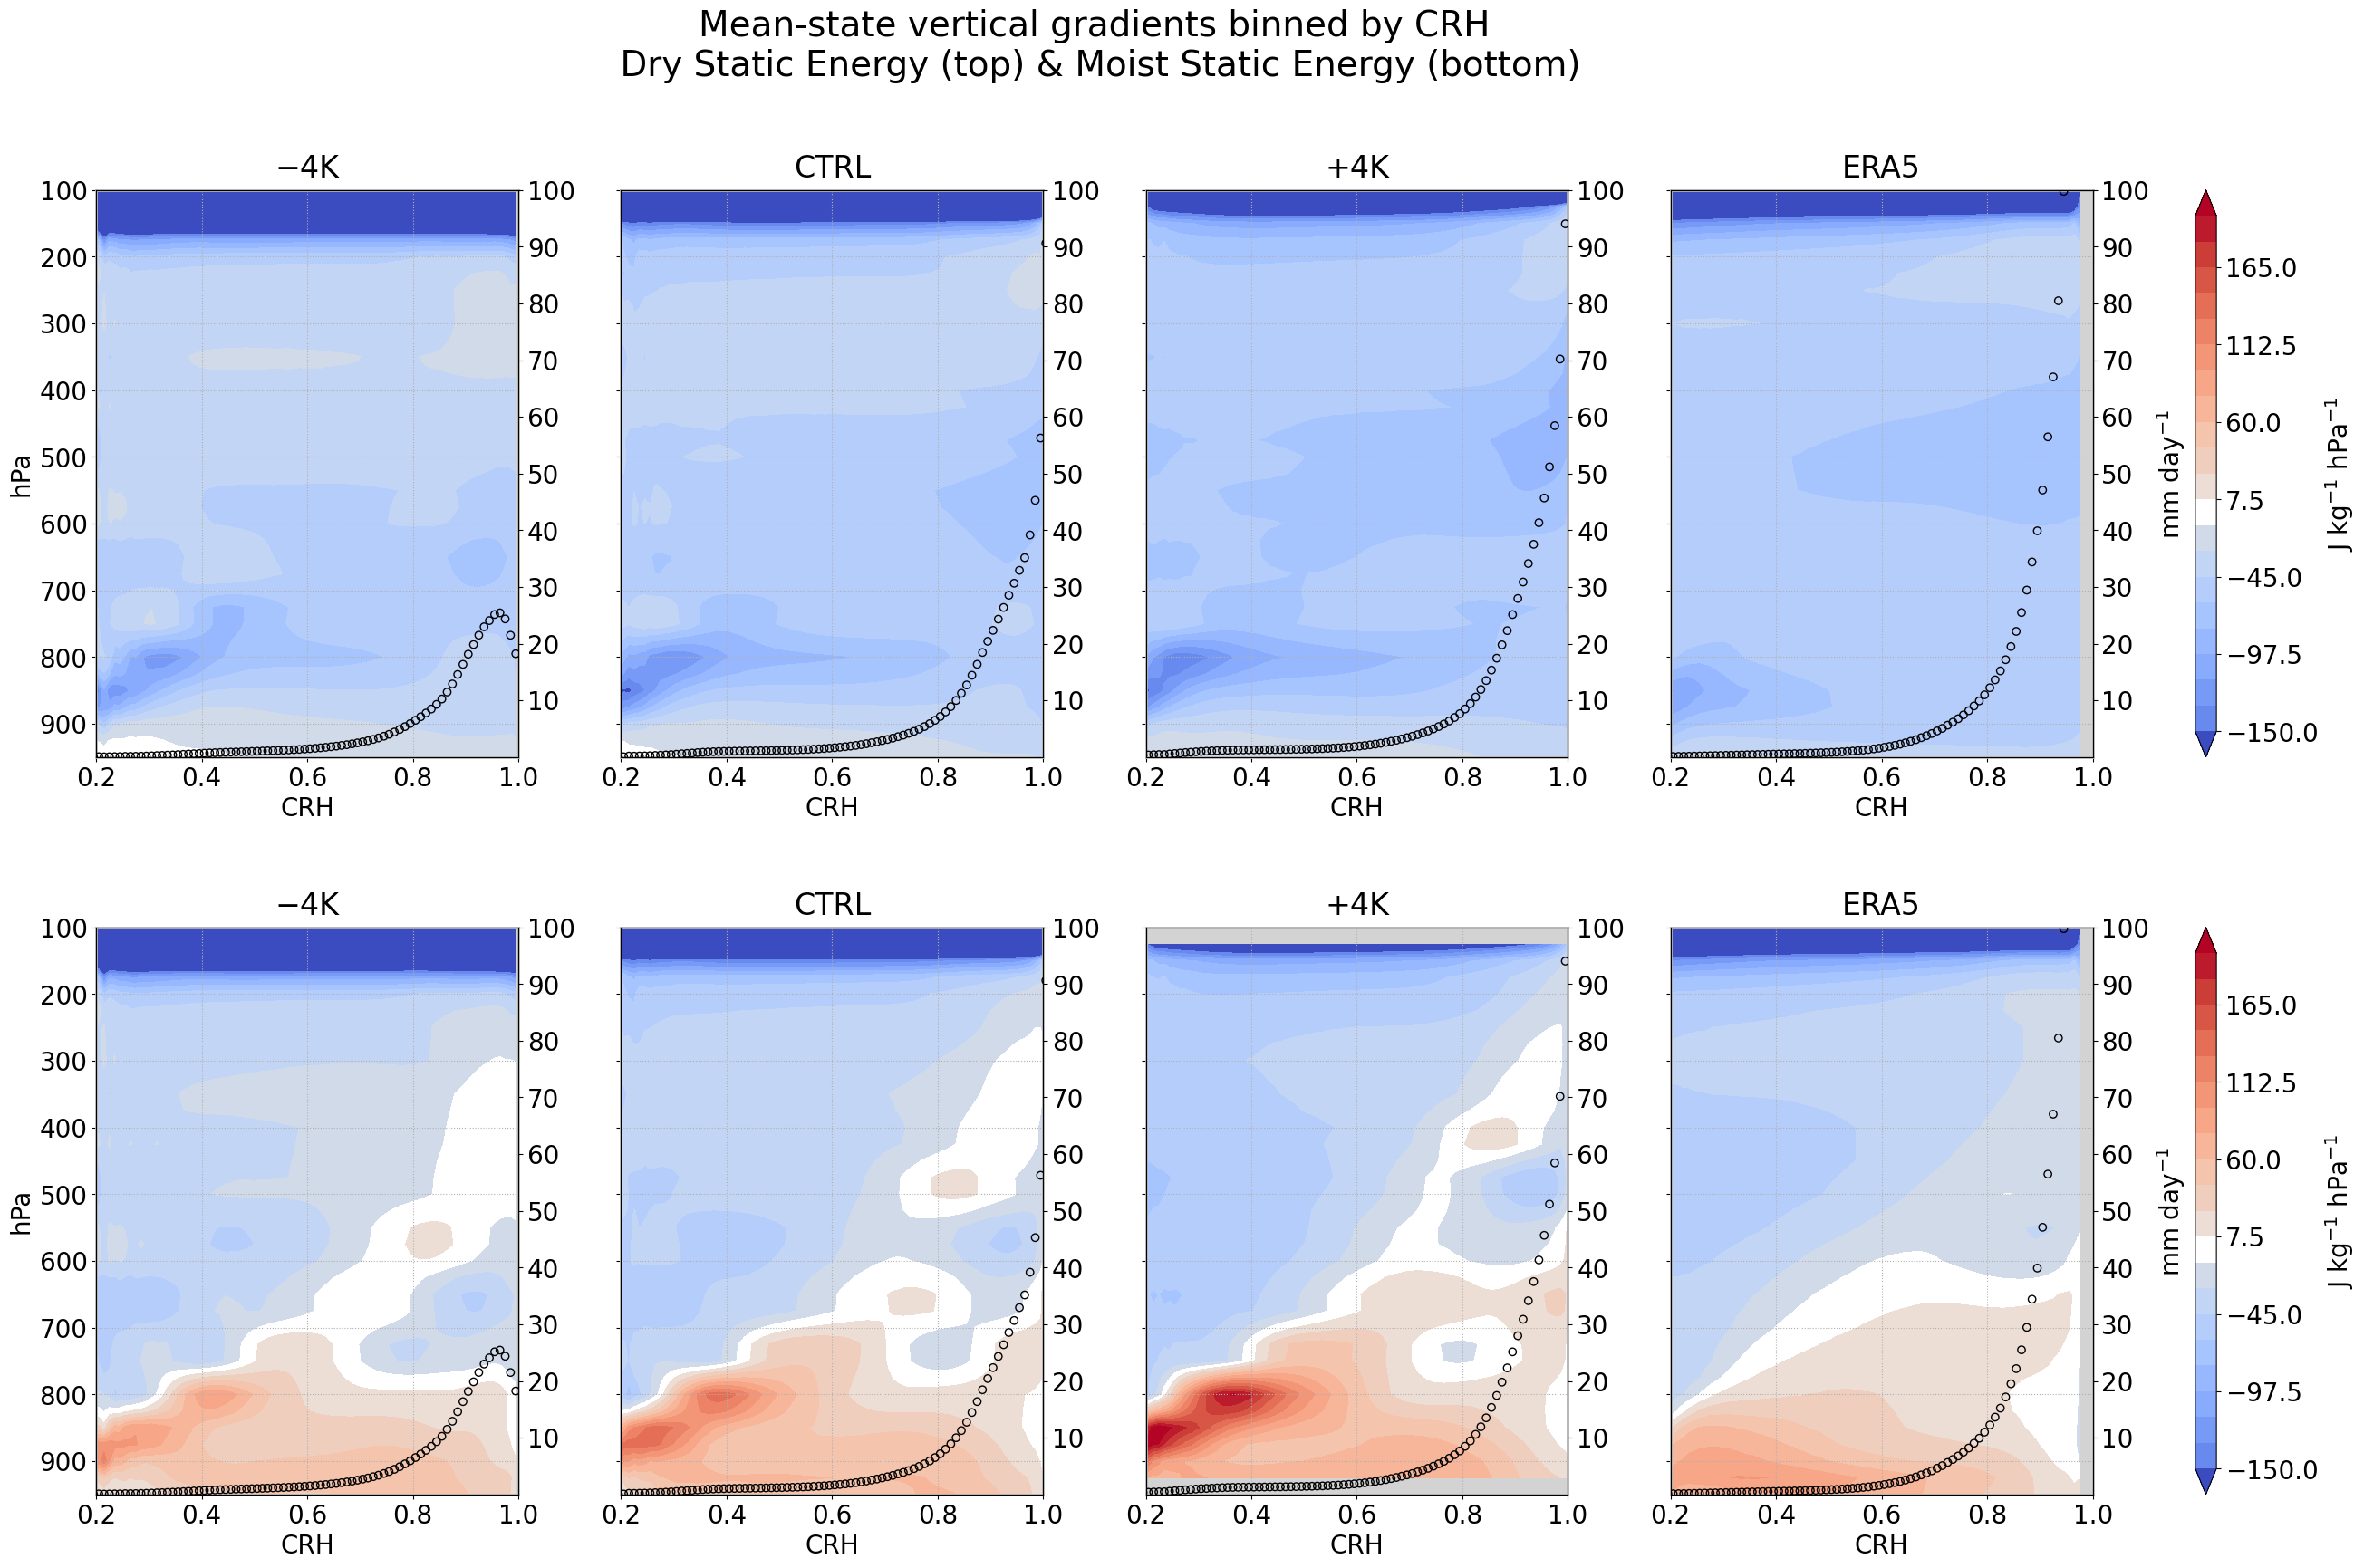

In [73]:
savefig = False
# variable_to_plot = 'alpha'

# variable_mean_over_CRH['Chikira alpha'] = alpha_by_CRH
# variable_mean_over_CRH['Moisture'].name = 'Moisture'
# variable_mean_over_CRH['Moisture'].attrs = multi_experiment_variables_subset['Moisture'].attrs
# variable_mean_over_CRH['Potential Temperature'].attrs = multi_experiment_variables_subset['Potential Temperature'].attrs

# scaled_moisture = 0.01*(HEAT_OF_VAPORIZATION/SPECIFIC_HEAT)*variable_mean_over_CRH['Moisture'].differentiate('plev')
# scaled_moisture.attrs = variable_mean_over_CRH['Moisture'].attrs
# scaled_moisture.attrs['units'] = 'K/hPa'

# scaled_potential_temperature = 0.01*(variable_mean_over_CRH['Potential Temperature']*exner_function).differentiate('plev')
# scaled_potential_temperature.attrs = variable_mean_over_CRH['Potential Temperature'].attrs
# scaled_potential_temperature.attrs['units'] = 'K/hPa'

scaled_DSE = variable_mean_over_CRH['Dry Static Energy']
scaled_DSE.attrs = variable_mean_over_CRH['Dry Static Energy'].attrs
scaled_DSE.attrs['units'] = r'kJ kg$^{-1}$'

scaled_MSE = variable_mean_over_CRH['Moist Static Energy']
scaled_MSE.attrs = variable_mean_over_CRH['Moist Static Energy'].attrs
scaled_MSE.attrs['units'] = r'kJ kg$^{-1}$'

variables_to_plot = [
    # variable_mean_over_CRH['Moist Static Energy'],
    # variable_mean_over_CRH['Dry Static Energy'],
    scaled_DSE.differentiate('plev'),
    scaled_MSE.differentiate('plev'),
]

ERA5_variables_to_plot = [
    ERA5_DSE_by_CRH.differentiate('plev'),
    ERA5_MSE_by_CRH.differentiate('plev'),
]

# colorbar_bounds = [
    # np.arange(0, 3.1, 0.1),
    # np.linspace(0, 0.003, 21),
    # np.linspace(0, 0.003, 21),
# ]

plt.rcParams.update({'font.size':20, 'mathtext.fontset':'dejavusans'})
fig = plt.figure(figsize=(26,16))

gs = GridSpec(2, 5, figure=fig, width_ratios = [20, 20, 20, 20, 1])
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, wspace=0.3, hspace=0.3)

for row_index, variable_data in enumerate(variables_to_plot):

    axes = []
    # grand_min = variable_mean_over_CRH[variable_to_plot].min()
    # grand_max = variable_mean_over_CRH[variable_to_plot].max()

    # grand_min = variable_data.min()
    # grand_max = variable_data.max()
    grand_min = -150
    grand_max = 200

    cbar_ax = fig.add_subplot(gs[row_index, -1])

    ERA5_mean = ERA5_variables_to_plot[variable_index].mean()

    for column_index, experiment in enumerate(experiments_list):
        axes.append(fig.add_subplot(gs[row_index, column_index]))
        axes[column_index].set_title(experiments_array.sel(experiment=experiment)['name'].item(), fontsize=24, pad=10)
        im = axes[column_index].contourf(
            variable_data.CRH,
            variable_data.plev,
            variable_data.sel(experiment=experiment).T,
            # levels=np.arange(0, 3+0.1, 0.1),
            # levels=colorbar_bounds[row_index],
            levels = np.linspace(grand_min, grand_max, 21),
            # cmap=(mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05) if variable_data.name == 'Chikira alpha' else 'viridis'),
            cmap=mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05),
            # norm=(mcolors.CenteredNorm(vcenter=1) if variable_data.name == 'Chikira alpha' else mcolors.Normalize()),
            # cmap='coolwarm',
            norm=mcolors.CenteredNorm(vcenter=0),
            extend=('max' if variable_data.name == 'Chikira alpha' else 'both')
        )
        # axes[index].yaxis.grid()
        axes[column_index].grid(True, ls=':')

        ax2 = plt.twinx()
        ax2.scatter(
            variable_mean_over_CRH['Precipitation'].CRH,
            variable_mean_over_CRH['Precipitation'].sel(experiment=experiment),
            label=experiment,
            # edgecolors=bmh_colors(index+1),
            edgecolors='k',
            facecolors='none',
            lw=1,
        )
        ax2.set_ylim(0, 100)
        ax2.set_yticks(np.arange(10,110,10))
        ax2.grid(False)
        # ax2.set_ylabel(r'mm day$^{-1}$')

    #### Add ERA5 data
    axes.append(fig.add_subplot(gs[row_index, column_index+1]))
    axes[column_index+1].set_title("ERA5", fontsize=24, pad=10)
    axes[column_index+1].contourf(
        ERA5_variables_to_plot[row_index].CRH,
        ERA5_variables_to_plot[row_index].plev,
        ERA5_variables_to_plot[row_index].T,
        levels = np.linspace(grand_min, grand_max, 21),
        # cmap=(mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05) if variable_data.name == 'Chikira alpha' else 'viridis'),
        cmap=mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05),
        # norm=(mcolors.CenteredNorm(vcenter=1) if variable_data.name == 'Chikira alpha' else mcolors.Normalize()),
        # cmap='coolwarm',
        norm=mcolors.CenteredNorm(vcenter=0),
        extend=('max' if variable_data.name == 'Chikira alpha' else 'both')
    )
    # axes[index+1].yaxis.grid()
    axes[column_index+1].grid(True, ls=':')

    ax2 = axes[column_index+1].twinx()
    ax2.scatter(
        ERA5_precipitation_by_CRH.CRH,
        SECONDS_PER_DAY*ERA5_precipitation_by_CRH,
        edgecolors='k',
        facecolors='none',
        lw=1,
        zorder=10
    )
    ax2.set_ylim(0, 100)
    ax2.set_yticks(np.arange(10,110,10))
    ax2.set_ylabel(r'mm day$^{-1}$')
    ax2.grid(False)

    cbar = fig.colorbar(im, cax=cbar_ax)
    # cbar.set_label(variable_data.attrs['units'])
    cbar.set_label(r"J kg$^{-1}$ hPa$^{-1}$")
    # cbar.set_ticks(np.arange(0, 3.25, 0.25))

    fig.suptitle(
        f"Mean-state vertical gradients binned by CRH\n Dry Static Energy (top) & Moist Static Energy (bottom)",
        x=(axes[0].get_position().x0 + axes[-1].get_position().x1)/2,
        ha='center',
        y=1.075,
        size=28
    )

    for index, ax in enumerate(axes):

        ax.set_facecolor('lightgrey')
        for edge in ["top", "bottom", "left", "right"]:
            ax.spines[edge].set_linewidth(2)
            ax.spines[edge].set_color("#bcbcbc")
        ax.set_xlabel('CRH')
        ax.set_xlim(0.2, 1)
        ax.set_xticks(np.arange(0.2, 1.2, 0.2))
        # ax.xaxis.set_major_locator(mticker.MaxNLocator(6, prune="lower"))
        if index == 0:
            ax.set_ylabel('hPa')
            ax.set_yticks(np.arange(100, 1100, 100))
        else:
            ax.set_yticks(np.arange(100, 1100, 100), labels=[])
        ax.set_ylim(100, 950)
        ax.invert_yaxis()

if not savefig:
    plt.show()
else:
    save_string = (
        f"multi-experiment_{variable_mean_over_CRH[variable_to_plot].attrs['file_id']}.png"
        )
    print(f"Saving plot as {save_string}")
    plt.savefig(
        f"{output_directory}/mean-state/variables_binned_by_CRH/{save_string}",
        dpi=500,
        bbox_inches="tight",
    )

# print(f"{'='*str_width}")
# print("Finished")

Saving plot as multi-experiment_variables-by-CRH_with-ERA5.png


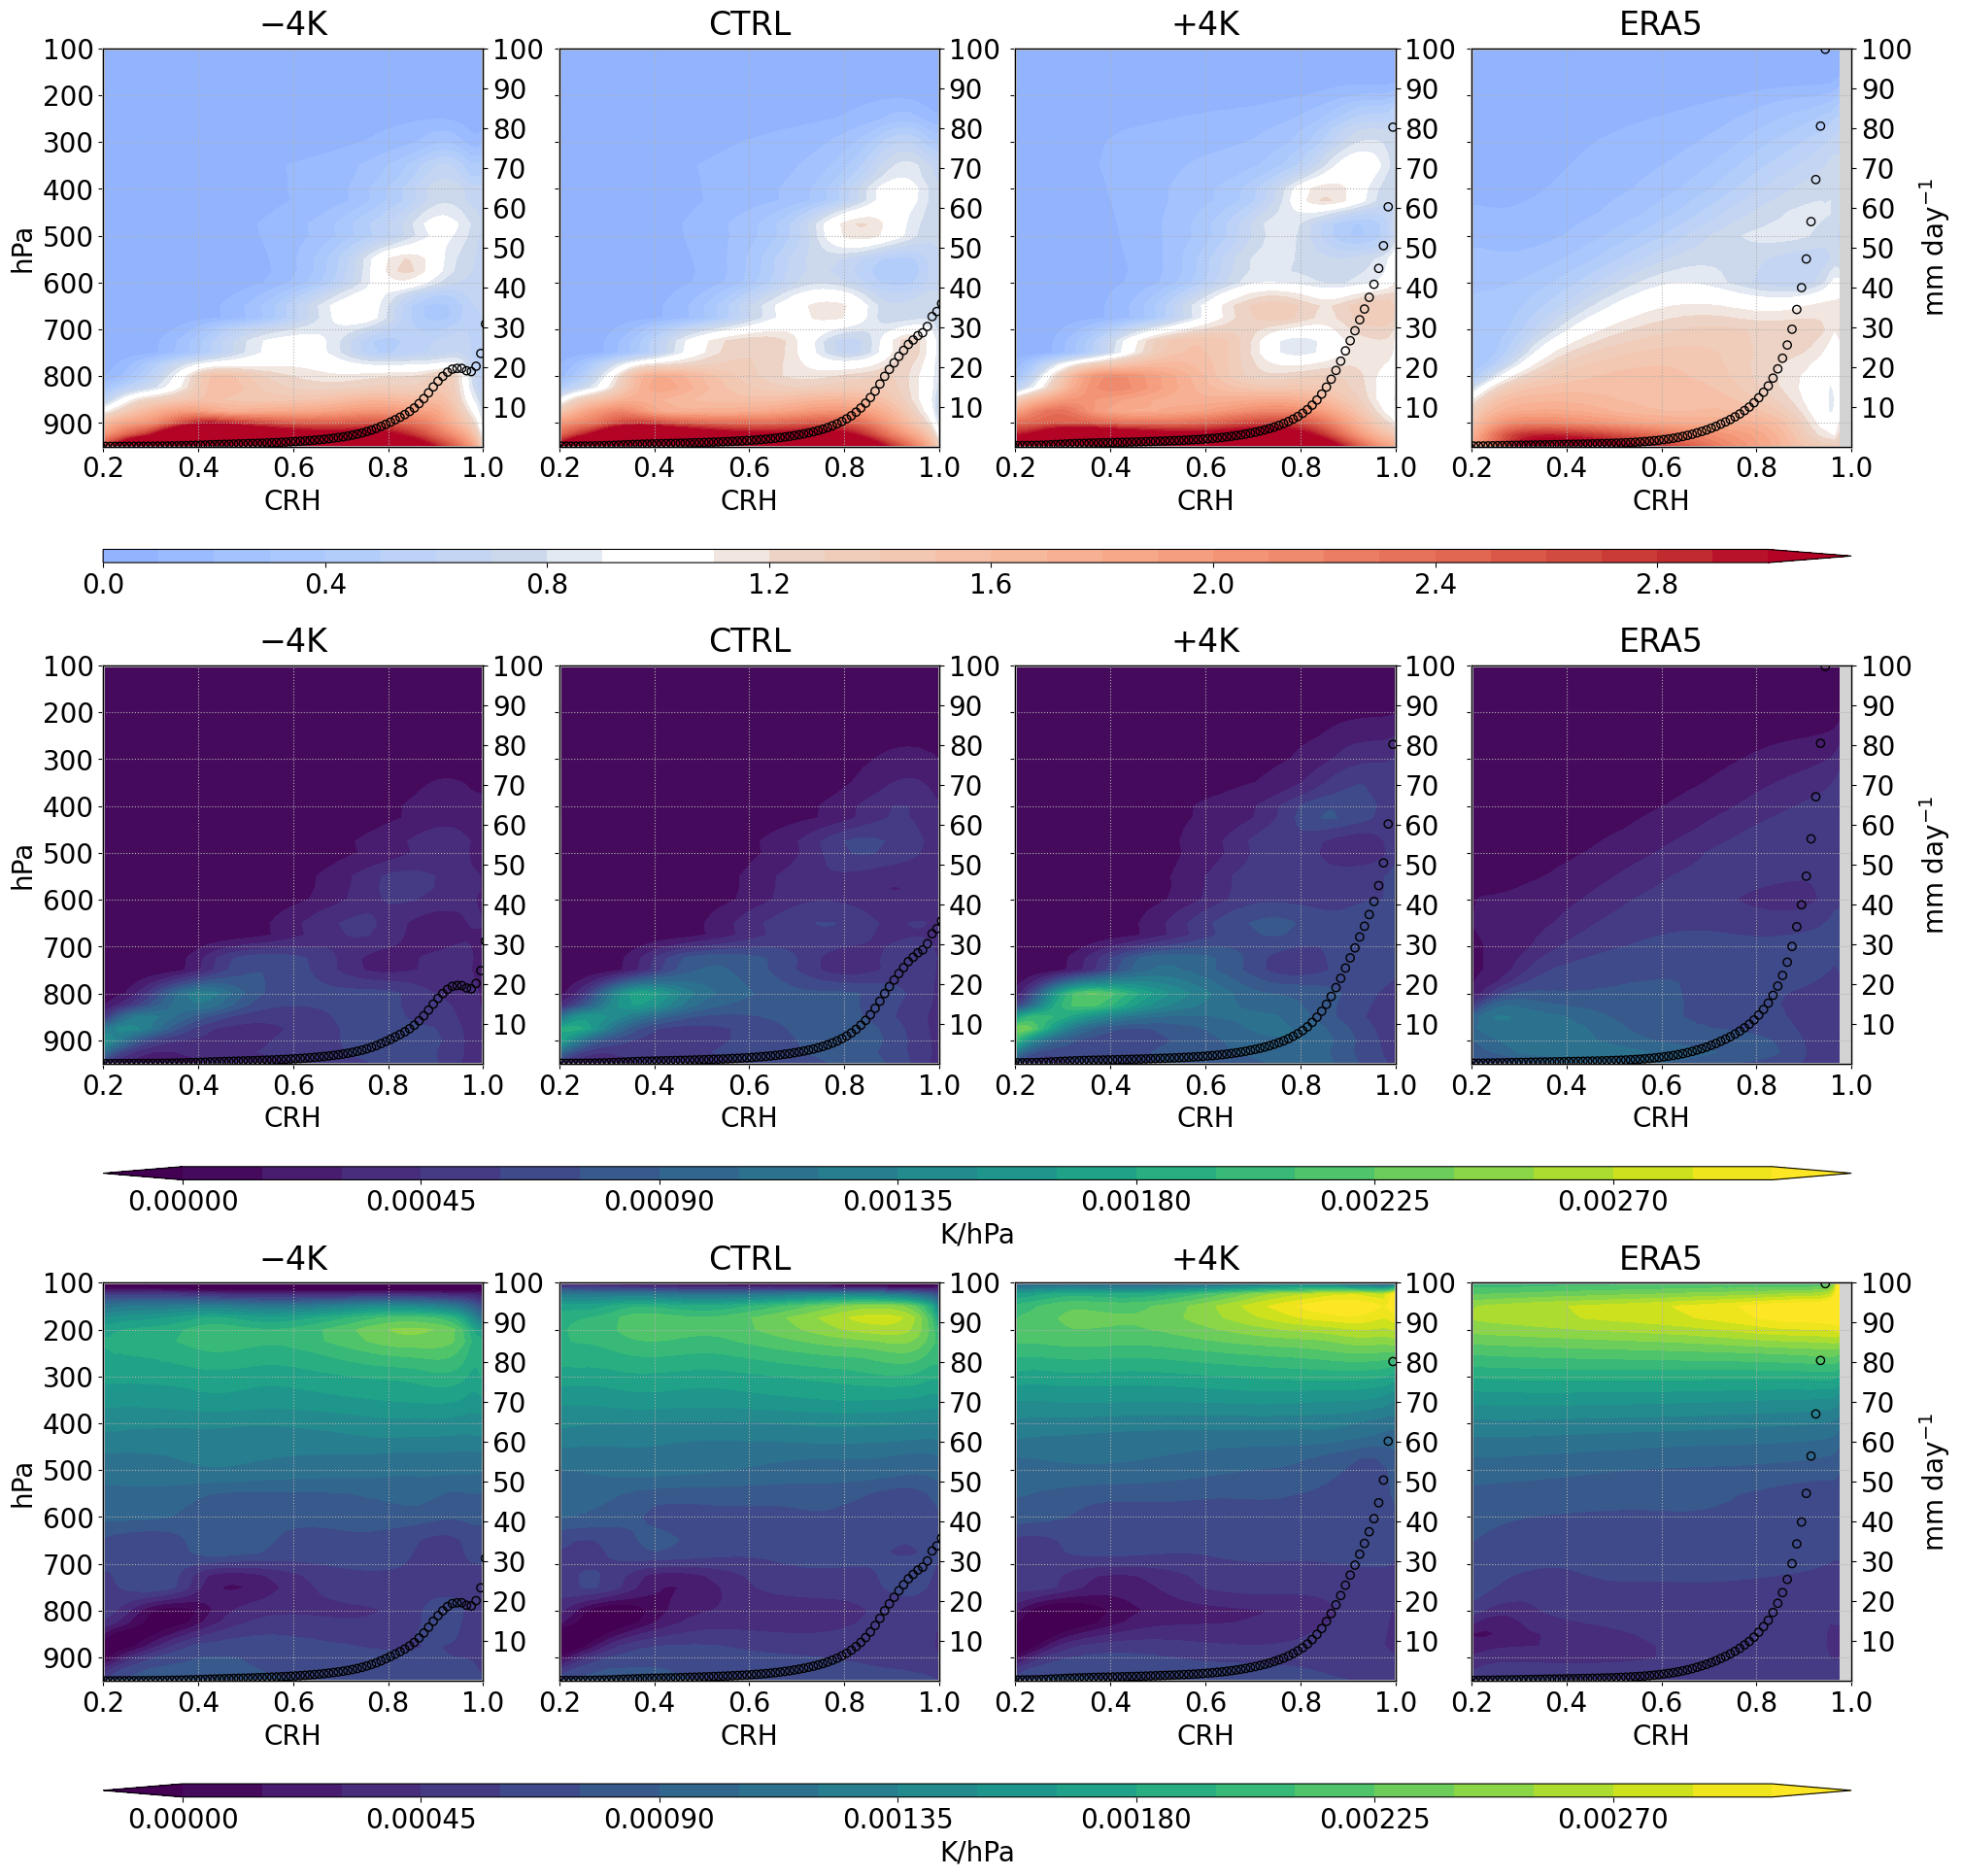

In [63]:
savefig = True
output_directory = f"/glade/u/home/sressel/aquaplanet_analysis/output"
# variable_to_plot = 'alpha'

scaled_moisture = 0.01*(HEAT_OF_VAPORIZATION/SPECIFIC_HEAT)*variable_mean_over_CRH['Moisture'].differentiate('plev')
scaled_moisture.name = 'Moisture'
scaled_moisture.attrs = multi_experiment_variables_subset['Moisture'].attrs
scaled_moisture.attrs['units'] = 'K/hPa'

scaled_potential_temperature = 0.01*(variable_mean_over_CRH['Potential Temperature']*exner_function).differentiate('plev')
scaled_potential_temperature.name = 'Potential Temperature'
scaled_potential_temperature.attrs = multi_experiment_variables_subset['Potential Temperature'].attrs
scaled_potential_temperature.attrs['units'] = 'K/hPa'

variable_mean_over_CRH['Chikira alpha'].name = 'Chikira alpha'
variables_to_plot = [
    variable_mean_over_CRH['Chikira alpha'],
    scaled_moisture,
    scaled_potential_temperature
]

scaled_ERA5_moisture = 0.01*(HEAT_OF_VAPORIZATION/SPECIFIC_HEAT)*ERA5_variables_by_CRH['Moisture'].differentiate('plev')
scaled_ERA5_moisture.name = 'Moisture'
scaled_ERA5_moisture.attrs = ERA5_variables_by_CRH['Moisture'].attrs
scaled_ERA5_moisture.attrs['units'] = 'K/hPa'

scaled_ERA5_potential_temperature = 0.01*(ERA5_variables_by_CRH['Potential Temperature']*exner_function).differentiate('plev')
scaled_ERA5_potential_temperature.name = 'Potential Temperature'
scaled_ERA5_potential_temperature.attrs = ERA5_variables_by_CRH['Potential Temperature'].attrs
scaled_ERA5_potential_temperature.attrs['units'] = 'K/hPa'

ERA5_variables_to_plot = [
    ERA5_variables_by_CRH['Chikira alpha'],
    scaled_ERA5_moisture,
    scaled_ERA5_potential_temperature
]

colorbar_bounds = [
    np.arange(0, 3.1, 0.1),
    np.linspace(0, 0.003, 21),
    np.linspace(0, 0.003, 21),
]
plt.rcParams.update({'font.size':20, 'mathtext.fontset':'dejavusans'})

fig = plt.figure(figsize=(20,20))

gs = GridSpec(6, 4, figure=fig, height_ratios=[30,1,30,1,30,1])
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, wspace=0.2, hspace=0.5)

for variable_index, variable_data in enumerate(variables_to_plot):

    variable_to_plot = variable_data.name

    row_index = int(2*variable_index)
    axes = []
    # grand_min = variable_mean_over_CRH[variable_to_plot].min()
    # grand_max = variable_mean_over_CRH[variable_to_plot].max()

    cbar_ax = fig.add_subplot(gs[row_index+1, :])

    for column_index, experiment in enumerate(experiments_list):
        axes.append(fig.add_subplot(gs[row_index, column_index]))
        axes[column_index].set_title(experiments_array.sel(experiment=experiment)['name'].item(), fontsize=24, pad=10)
        im = axes[column_index].contourf(
            variable_data.CRH,
            variable_data.plev,
            variable_data.sel(experiment=experiment).T,
            # levels=np.arange(0, 3+0.1, 0.1),
            levels=colorbar_bounds[variable_index],
            cmap=(mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05) if variable_data.name == 'Chikira alpha' else 'viridis'),
            norm=(mcolors.CenteredNorm(vcenter=1) if variable_data.name == 'Chikira alpha' else mcolors.Normalize()),
            extend=('max' if variable_data.name == 'Chikira alpha' else 'both')
        )
        # axes[index].yaxis.grid()
        axes[column_index].grid(True, ls=':')

        ax2 = plt.twinx()
        ax2.scatter(
            variable_mean_over_CRH['Precipitation'].CRH,
            variable_mean_over_CRH['Precipitation'].sel(experiment=experiment),
            label=experiment,
            # edgecolors=bmh_colors(index+1),
            edgecolors='k',
            facecolors='none',
            lw=1,
        )
        ax2.set_ylim(0, 100)
        ax2.set_yticks(np.arange(10,110,10))
        ax2.grid(False)
        # ax2.set_ylabel(r'mm day$^{-1}$')

    #### Add ERA5 data
    axes.append(fig.add_subplot(gs[row_index, column_index+1]))
    axes[column_index+1].set_title("ERA5", fontsize=24, pad=10)
    axes[column_index+1].contourf(
        ERA5_variables_to_plot[variable_index].CRH,
        ERA5_variables_to_plot[variable_index].plev,
        ERA5_variables_to_plot[variable_index].T,
        levels=colorbar_bounds[variable_index],
        cmap=(mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05) if variable_data.name == 'Chikira alpha' else 'viridis'),
        norm=(mcolors.CenteredNorm(vcenter=1) if variable_data.name == 'Chikira alpha' else mcolors.Normalize()),
        extend=('max' if variable_data.name == 'Chikira alpha' else 'both')
    )
    # axes[index+1].yaxis.grid()
    axes[column_index+1].grid(True, ls=':')

    ax2 = axes[column_index+1].twinx()
    ax2.scatter(
        ERA5_precipitation_by_CRH.CRH,
        SECONDS_PER_DAY*ERA5_precipitation_by_CRH,
        edgecolors='k',
        facecolors='none',
        lw=1,
        zorder=10
    )
    ax2.set_ylim(0, 100)
    ax2.set_yticks(np.arange(10,110,10))
    ax2.set_ylabel(r'mm day$^{-1}$')
    ax2.grid(False)

    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(variable_data.attrs['units'])

    # cbar.set_ticks(np.arange(0, 3.25, 0.25))

    # fig.suptitle(
    #     f"Mean-state {variable_data.attrs['short_name']} binned by CRH",
    #     x=(axes[0].get_position().x0 + axes[-1].get_position().x1)/2,
    #     ha='center',
    #     y=1.075,
    #     size=28
    # )

    for index, ax in enumerate(axes):

        ax.set_facecolor('lightgrey')
        for edge in ["top", "bottom", "left", "right"]:
            ax.spines[edge].set_linewidth(2)
            ax.spines[edge].set_color("#bcbcbc")
        ax.set_xlabel('CRH')
        ax.set_xlim(0.2, 1)
        ax.set_xticks(np.arange(0.2, 1.2, 0.2))
        # ax.xaxis.set_major_locator(mticker.MaxNLocator(6, prune="lower"))
        if index == 0:
            ax.set_ylabel('hPa')
            ax.set_yticks(np.arange(100, 1100, 100))
        else:
            ax.set_yticks(np.arange(100, 1100, 100), labels=[])
        ax.set_ylim(100, 950)
        ax.invert_yaxis()

if not savefig:
    plt.show()
else:
    save_string = (
        f"multi-experiment_variables-by-CRH_with-ERA5.png"
        )
    print(f"Saving plot as {save_string}")
    plt.savefig(
        f"{output_directory}/mean-state/variables_binned_by_CRH/{save_string}",
        dpi=500,
        bbox_inches="tight",
    )

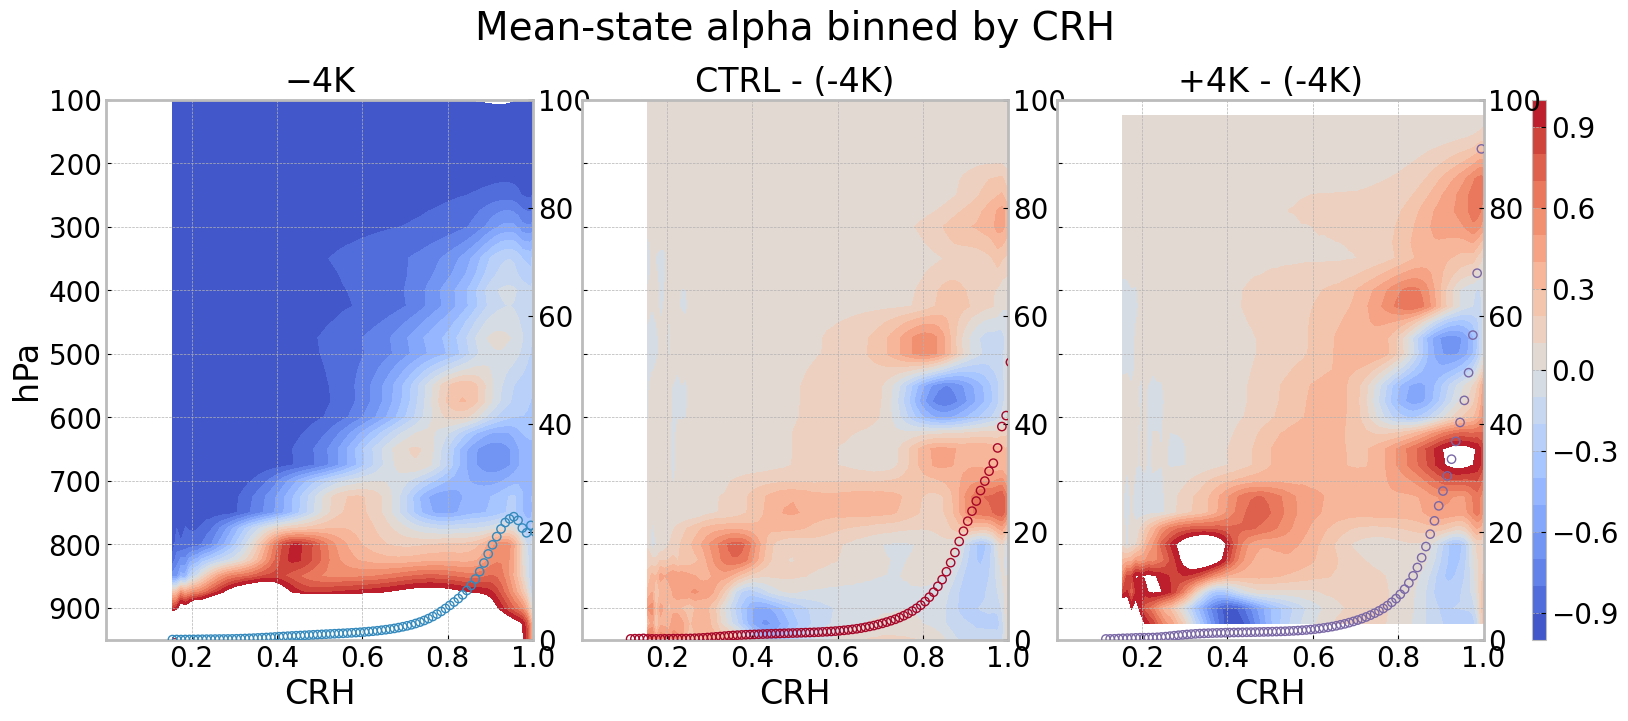

In [171]:
variable_to_plot = 'alpha'

variable_mean_over_CRH['alpha'] = alpha
plt.rcParams.update({'font.size':20, 'mathtext.fontset':'dejavusans'})

fig = plt.figure(figsize=(16,6))
gs = GridSpec(1, 4, figure=fig, width_ratios=[30,30,30,1])
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, wspace=0.15)
axes = []
grand_min = variable_mean_over_CRH[variable_to_plot].min()
grand_max = variable_mean_over_CRH[variable_to_plot].max()

cbar_ax = fig.add_subplot(gs[-1])
pr_ax = []

for index, experiment in enumerate(experiments_list):
    axes.append(fig.add_subplot(gs[index]))
    if index == 0:
        axes[index].set_title(experiments_array.sel(experiment=experiment)['name'].item(), fontsize=24)
        im = axes[index].contourf(
            variable_mean_over_CRH[variable_to_plot].CRH,
            variable_mean_over_CRH[variable_to_plot].plev,
            variable_mean_over_CRH[variable_to_plot].sel(experiment=experiment),
            levels=np.arange(0, 2+0.1, 0.1),
            cmap='coolwarm',
            norm=mcolors.CenteredNorm(vcenter=1)
        )
    else:
        axes[index].set_title(
            f"{experiments_array.sel(experiment=experiment)['name'].item()} - (-4K)",
            fontsize=24
        )
        im = axes[index].contourf(
            variable_mean_over_CRH[variable_to_plot].CRH,
            variable_mean_over_CRH[variable_to_plot].plev,
            (
                variable_mean_over_CRH[variable_to_plot].sel(experiment=experiment)
             - variable_mean_over_CRH[variable_to_plot].sel(experiment='-4K')
            ),
            # levels=np.linspace(grand_min, grand_max, 21),
            levels=np.arange(-1, 1+0.1, 0.1),
            # cmap=mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05),
            # cmap='YlOrRd'
            cmap='coolwarm',
            norm=mcolors.CenteredNorm(vcenter=0)
            # cmap = plotting_attributes[variable_to_plot].get('d_cmap'),
            # norm = plotting_attributes[variable_to_plot].get('norm')
        )

    ax2 = plt.twinx()
    ax2.scatter(
        variable_mean_over_CRH['Precipitation'].CRH,
        variable_mean_over_CRH['Precipitation'].sel(experiment=experiment),
        label=experiment,
        edgecolors=bmh_colors(index+1),
        facecolors='none',
        lw=1,
        zorder=10
    )
    ax2.set_ylim(0, 100)
    ax2.grid(False)

cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(variable_mean_over_CRH[variable_to_plot].attrs['units'])

fig.suptitle(
    f"Mean-state {variable_to_plot} binned by CRH",
    x=(axes[0].get_position().x0 + axes[2].get_position().x1)/2,
    ha='center',
    y=1.1,
    size=28
)

for index, ax in enumerate(axes):

    ax.set_facecolor('white')
    for edge in ["top", "bottom", "left", "right"]:
        ax.spines[edge].set_linewidth(2)
        ax.spines[edge].set_color("#bcbcbc")
    ax.set_xlabel('CRH')
    ax.set_xlim(0, 1)
    ax.set_xticks(np.arange(0, 1.2, 0.2))
    ax.xaxis.set_major_locator(mticker.MaxNLocator(6, prune="lower"))
    if index == 0:
        ax.set_ylabel('hPa')
        ax.set_yticks(np.arange(100, 1100, 100))
    else:
        ax.set_yticks(np.arange(100, 1100, 100), labels=[])
    ax.set_ylim(100, 950)
    ax.invert_yaxis()

plt.show()
###### Add separate colorbar for left-most plot #######

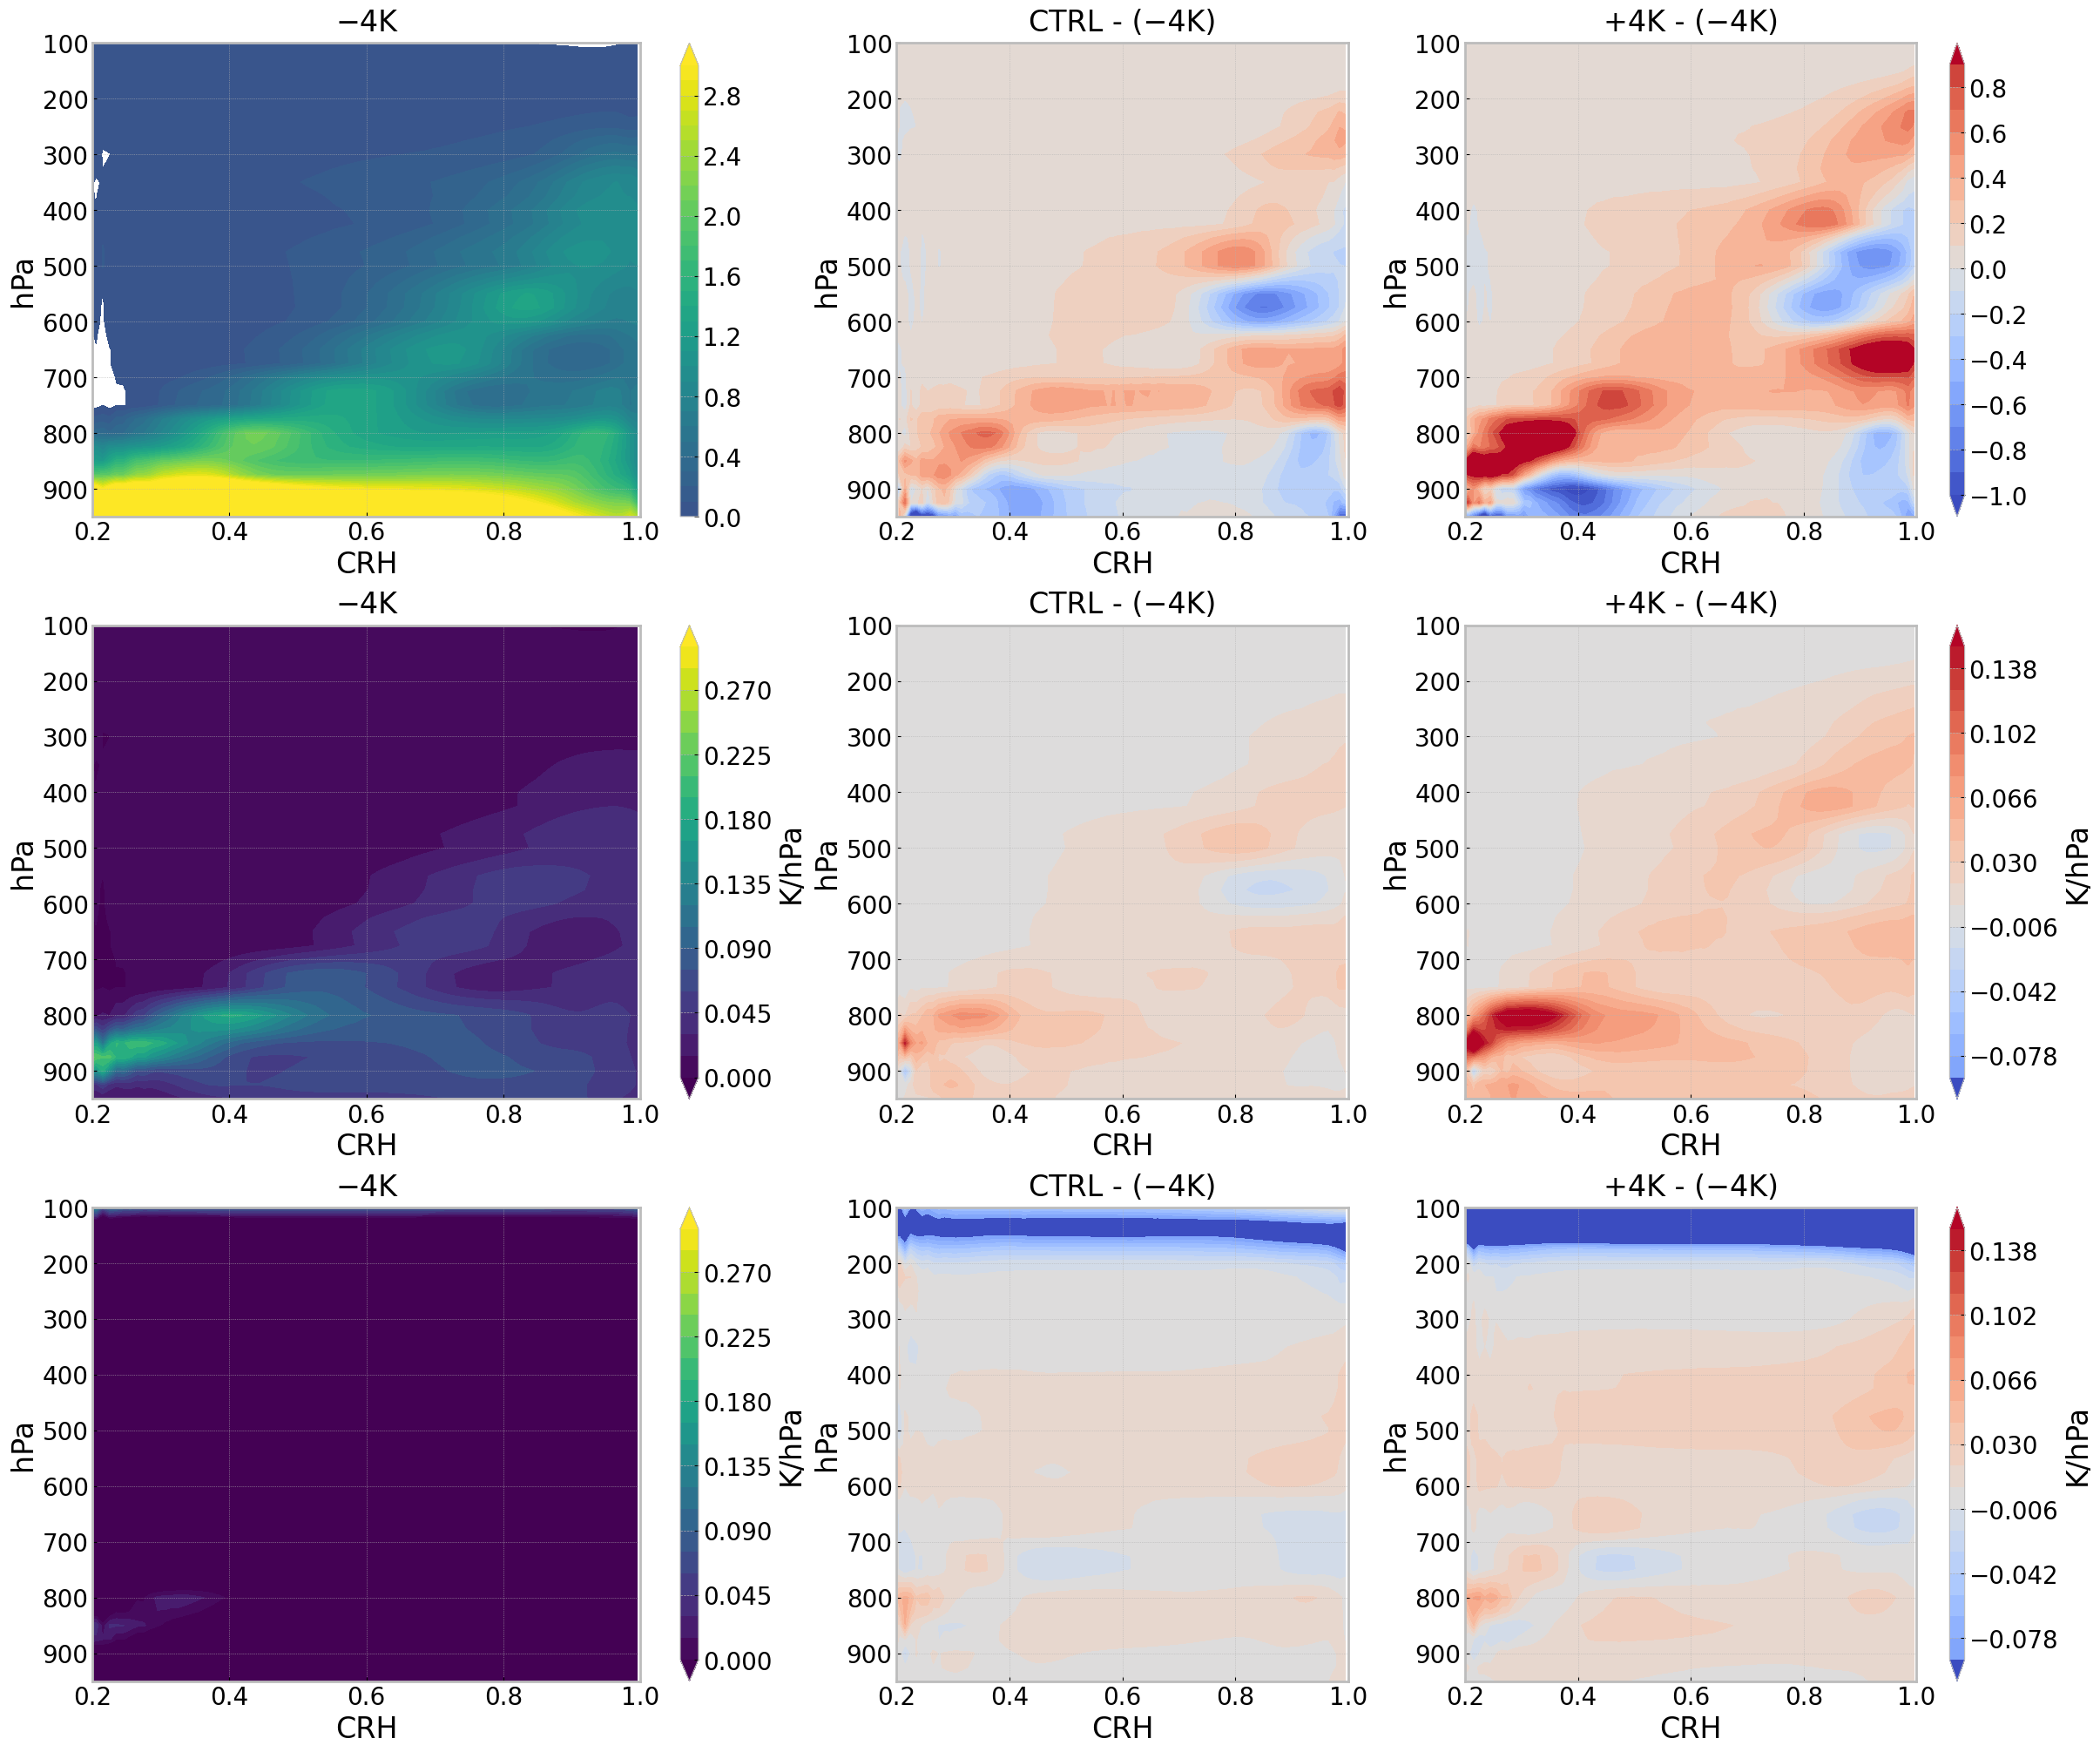

In [30]:
savefig = False
# variable_to_plot = 'alpha'

variable_mean_over_CRH['Moisture'].name = 'Moisture'
variable_mean_over_CRH['Moisture'].attrs = multi_experiment_variables_subset['Moisture'].attrs
variable_mean_over_CRH['Potential Temperature'].attrs = multi_experiment_variables_subset['Potential Temperature'].attrs

scaled_moisture = (HEAT_OF_VAPORIZATION/SPECIFIC_HEAT)*variable_mean_over_CRH['Moisture'].differentiate('plev')
scaled_moisture.name = 'Moisture'
scaled_moisture.attrs = variable_mean_over_CRH['Moisture'].attrs
scaled_moisture.attrs['units'] = 'K/hPa'

scaled_potential_temperature = -(variable_mean_over_CRH['Potential Temperature']*exner_function).differentiate('plev')
scaled_potential_temperature.name = 'Potential Temperature'
scaled_potential_temperature.attrs = variable_mean_over_CRH['Potential Temperature'].attrs
scaled_potential_temperature.attrs['units'] = 'K/hPa'

variables_to_plot = [
    variable_mean_over_CRH['Chikira alpha'],
    scaled_moisture,
    scaled_potential_temperature
]

colorbar_bounds = [
    np.arange(0, 3.1, 0.1),
    np.linspace(0, 0.3, 21),
    np.linspace(0, 0.3, 21),
]
difference_colorbar_bounds = [
    np.arange(-1, 1, 0.1),
    np.linspace(-0.09, 0.15, 21),
    np.linspace(-0.09, 0.15, 21),
]
plt.rcParams.update({'font.size':20, 'mathtext.fontset':'dejavusans'})

fig = plt.figure(figsize=(24,20), layout='constrained')
gs_main = fig.add_gridspec(1, 2, wspace=0.5, width_ratios=[1.25, 2])

gs_base = gs_main[0].subgridspec(3, 2, width_ratios = [30, 1])
gs_difference = gs_main[1].subgridspec(3, 3, width_ratios = [30, 30, 1])

base_axes = []
base_cbar_ax = []

difference_cbar_axes = []

for row_index, variable_data in enumerate(variables_to_plot):

    difference_axes = []
    difference_cbar_axes.append(fig.add_subplot(gs_difference[row_index, -1]))
    # print(row_index)
    base_axes.append(fig.add_subplot(gs_base[row_index, 0]))
    base_cbar_ax.append(fig.add_subplot(gs_base[row_index, -1]))

    base_axes[row_index].set_title(experiments_array.sel(experiment='-4K')['name'].item(), fontsize=24, pad=10)
    im = base_axes[row_index].contourf(
        variable_data.CRH,
        variable_data.plev,
        variable_data.sel(experiment='-4K').T,
        levels=colorbar_bounds[row_index],
        cmap=('viridis' if variable_data.name == 'Chikira alpha' else 'viridis'),
        # cmap='coolwarm',
        # norm=(mcolors.CenteredNorm(vcenter=1) if variable_data.name == 'Chikira alpha' else mcolors.CenteredNorm(0)),
        norm=(mcolors.CenteredNorm(vcenter=1) if variable_data.name == 'Chikira alpha' else mcolors.Normalize()),
        extend=('max' if variable_data.name == 'Chikira alpha' else 'both')
    )
    # base_axes[row_index].contour(
    #     variable_data.CRH,
    #     variable_data.plev,
    #     variable_data.sel(experiment='-4K').T,
    #     # levels=np.arange(0, 3+0.1, 0.1),
    #     levels=colorbar_bounds[row_index],
    #     cmap=('coolwarm' if variable_data.name == 'Chikira alpha' else 'YlOrBr'),
    #     lw=1
    # )

    cbar = fig.colorbar(im, cax=base_cbar_ax[row_index])
    cbar.set_label(variable_data.attrs['units'])

    base_axes[row_index].set_facecolor('white')
    for edge in ["top", "bottom", "left", "right"]:
        base_axes[row_index].spines[edge].set_linewidth(2)
        base_axes[row_index].spines[edge].set_color("#bcbcbc")
    base_axes[row_index].set_xlabel('CRH')
    base_axes[row_index].set_xlim(0.2, 1)
    base_axes[row_index].set_xticks(np.arange(0.2, 1.2, 0.2))
    # ax.xaxis.set_major_locator(mticker.MaxNLocator(6, prune="lower"))

    base_axes[row_index].set_ylabel('hPa')
    base_axes[row_index].set_yticks(np.arange(100, 1100, 100))

    base_axes[row_index].set_ylim(100, 950)
    base_axes[row_index].invert_yaxis()
    base_axes[row_index].grid(True, ls=':')

    for column_index, experiment in enumerate(experiments_list[1:]):
        difference_axes.append(fig.add_subplot(gs_difference[row_index, column_index]))
        difference_axes[column_index].set_title(
            f"{experiments_array.sel(experiment=experiment)['name'].item()} - ({experiments_array.sel(experiment='-4K')['name'].item()})",
            fontsize=24,
            pad=10
        )
        im = difference_axes[column_index].contourf(
            variable_data.CRH,
            variable_data.plev,
            (
                variable_data.sel(experiment=experiment).T
                - variable_data.sel(experiment='-4K').T
            ),
            # levels=np.arange(0, 3+0.1, 0.1),
            levels=difference_colorbar_bounds[row_index],
            # cmap=mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05),
            # cmap='coolwarm',
            cmap=('coolwarm' if variable_data.name == 'Chikira alpha' else 'coolwarm'),
            # cmap='Spectral',
            norm=mcolors.CenteredNorm(vcenter=0),
            extend='both'
        )

        # ax2 = difference_axes[column_index].twinx()
        # ax2.scatter(
        #     variable_mean_over_CRH['Precipitation'].CRH,
        #     variable_mean_over_CRH['Precipitation'].sel(experiment=experiment),
        #     label=experiment,
        #     edgecolors='k',
        #     facecolors='none',
        #     lw=1,
        #     zorder=10
        # )
        # ax2.set_ylim(0, 100)
        # ax2.grid(False)

        difference_axes[column_index].set_facecolor('white')
        for edge in ["top", "bottom", "left", "right"]:
            difference_axes[column_index].spines[edge].set_linewidth(2)
            difference_axes[column_index].spines[edge].set_color("#bcbcbc")
        difference_axes[column_index].set_xlabel('CRH')
        difference_axes[column_index].set_xlim(0.2, 1)
        difference_axes[column_index].set_xticks(np.arange(0.2, 1.2, 0.2))
        # ax.xaxis.set_major_locator(mticker.MaxNLocator(6, prune="lower"))

        difference_axes[column_index].set_ylabel('hPa')
        difference_axes[column_index].set_yticks(np.arange(100, 1100, 100))

        difference_axes[column_index].set_ylim(100, 950)
        difference_axes[column_index].invert_yaxis()
        difference_axes[column_index].grid(True, ls=':')

    cbar = fig.colorbar(im, cax=difference_cbar_axes[row_index])
    cbar.set_label(variable_data.attrs['units'])

# if not savefig:
#     plt.show()
# else:
#     save_string = (
#         f"multi-experiment_{variable_mean_over_CRH[variable_to_plot].attrs['file_id']}.png"
#         )
#     print(f"Saving plot as {save_string}")
#     plt.savefig(
#         f"{output_directory}/mean-state/variables_binned_by_CRH/{save_string}",
#         dpi=500,
#         bbox_inches="tight",
#     )

# print(f"{'='*str_width}")
# print("Finished")

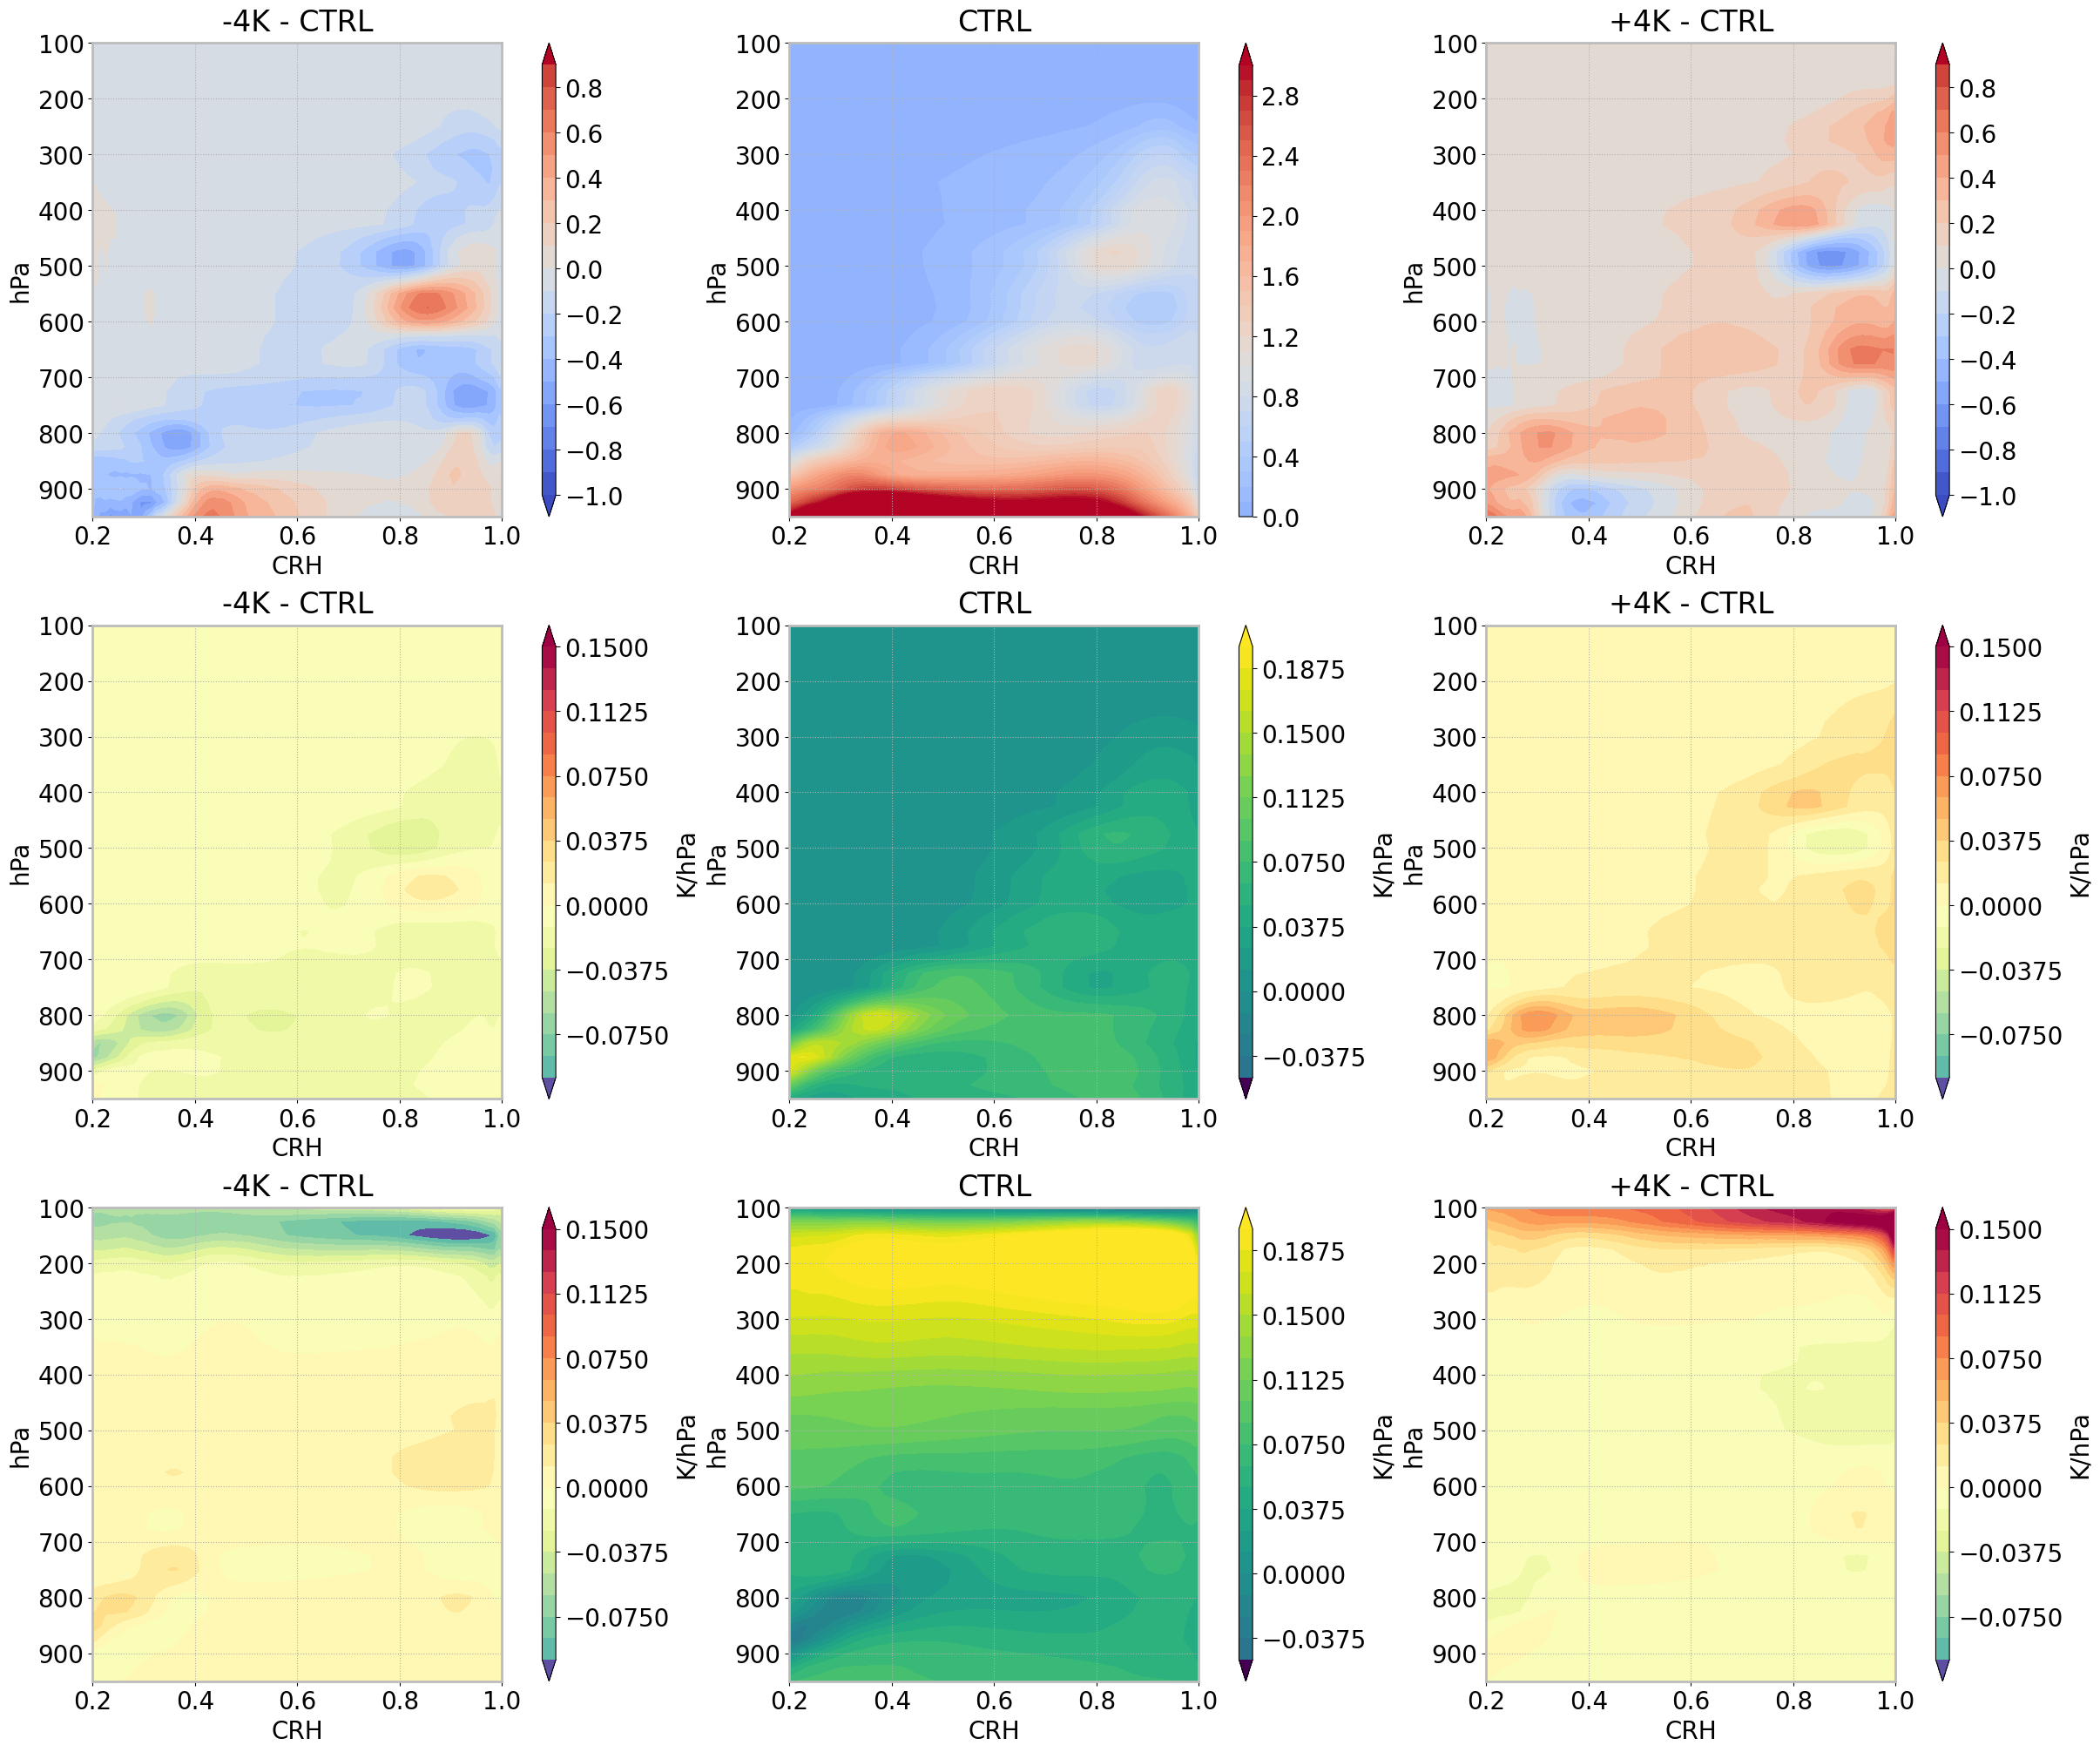

In [196]:
savefig = False
# variable_to_plot = 'alpha'

variable_mean_over_CRH['Moisture'].name = 'Moisture'
variable_mean_over_CRH['Moisture'].attrs = multi_experiment_variables_subset['Moisture'].attrs
variable_mean_over_CRH['Potential Temperature'].attrs = multi_experiment_variables_subset['Potential Temperature'].attrs

scaled_moisture = (HEAT_OF_VAPORIZATION/SPECIFIC_HEAT)*variable_mean_over_CRH['Moisture'].differentiate('plev')
scaled_moisture.name = 'Moisture'
scaled_moisture.attrs = variable_mean_over_CRH['Moisture'].attrs
scaled_moisture.attrs['units'] = 'K/hPa'

scaled_potential_temperature = (variable_mean_over_CRH['Potential Temperature']*exner_function).differentiate('plev')
scaled_potential_temperature.name = 'Potential Temperature'
scaled_potential_temperature.attrs = variable_mean_over_CRH['Potential Temperature'].attrs
scaled_potential_temperature.attrs['units'] = 'K/hPa'

variables_to_plot = [
    variable_mean_over_CRH['Chikira alpha'],
    scaled_moisture,
    scaled_potential_temperature
]

colorbar_bounds = [
    np.arange(0, 3.1, 0.1),
    np.linspace(-0.05, 0.2, 21),
    np.linspace(-0.05, 0.2, 21),
]
difference_colorbar_bounds = [
    np.arange(-1, 1, 0.1),
    np.linspace(-0.10, 0.15, 21),
    np.linspace(-0.10, 0.15, 21),
]
plt.rcParams.update({'font.size':20, 'mathtext.fontset':'dejavusans'})

fig = plt.figure(figsize=(24,20), layout='constrained')
gs_main = fig.add_gridspec(1, 3, wspace=0.2, width_ratios=[1, 1, 1])

gs_left = gs_main[0].subgridspec(3, 2, width_ratios = [30, 1])
gs_center = gs_main[1].subgridspec(3, 2, width_ratios = [30, 1])
gs_right = gs_main[2].subgridspec(3, 2, width_ratios = [30, 1])

left_axes = []
center_axes = []
right_axes = []

left_cbar_axes = []
center_cbar_axes = []
right_cbar_axes = []

for row_index, variable_data in enumerate(variables_to_plot):

    left_axes.append(fig.add_subplot(gs_left[row_index, 0]))
    center_axes.append(fig.add_subplot(gs_center[row_index, 0]))
    right_axes.append(fig.add_subplot(gs_right[row_index, 0]))

    left_cbar_axes.append(fig.add_subplot(gs_left[row_index, -1]))
    center_cbar_axes.append(fig.add_subplot(gs_center[row_index, -1]))
    right_cbar_axes.append(fig.add_subplot(gs_right[row_index, -1]))

    center_axes[row_index].set_title(experiments_array.sel(experiment='0K')['name'].item(), fontsize=24, pad=10)
    im = center_axes[row_index].contourf(
        variable_data.CRH,
        variable_data.plev,
        variable_data.sel(experiment='0K').T,
        levels=colorbar_bounds[row_index],
        # levels=21,
        cmap=('coolwarm' if variable_data.name == 'Chikira alpha' else 'viridis'),
        # cmap='coolwarm',
        norm=(mcolors.CenteredNorm(vcenter=1) if variable_data.name == 'Chikira alpha' else mcolors.CenteredNorm(0)),
        extend=('max' if variable_data.name == 'Chikira alpha' else 'both')
    )

    cbar = fig.colorbar(im, cax=center_cbar_axes[row_index])
    cbar.set_label(variable_data.attrs['units'])

    left_axes[row_index].set_title(
        f"-4K - {experiments_array.sel(experiment='0K')['name'].item()}",
        fontsize=24,
        pad=10
    )
    im = left_axes[row_index].contourf(
        variable_data.CRH,
        variable_data.plev,
        (
            variable_data.sel(experiment='-4K').T
            - variable_data.sel(experiment='0K').T
        ),
        levels=difference_colorbar_bounds[row_index],
        # levels=21,
        cmap=('coolwarm' if variable_data.name == 'Chikira alpha' else 'Spectral_r'),
        # cmap='coolwarm',
        # norm=(mcolors.CenteredNorm(vcenter=1) if variable_data.name == 'Chikira alpha' else mcolors.CenteredNorm(0)),
        norm=mcolors.CenteredNorm(vcenter=0),
        extend='both'
    )

    cbar = fig.colorbar(im, cax=left_cbar_axes[row_index])
    cbar.set_label(variable_data.attrs['units'])

    right_axes[row_index].set_title(
        f"+4K - {experiments_array.sel(experiment='0K')['name'].item()}",
        fontsize=24,
        pad=10
    )
    im = right_axes[row_index].contourf(
        variable_data.CRH,
        variable_data.plev,
        (
            variable_data.sel(experiment='4K').T
            - variable_data.sel(experiment='0K').T
        ),
        levels=difference_colorbar_bounds[row_index],
        # levels=21,
        cmap=('coolwarm' if variable_data.name == 'Chikira alpha' else 'Spectral_r'),
        # cmap='coolwarm',
        # norm=(mcolors.CenteredNorm(vcenter=1) if variable_data.name == 'Chikira alpha' else mcolors.CenteredNorm(0)),
        norm=mcolors.CenteredNorm(vcenter=0),
        extend='both'
    )

    cbar = fig.colorbar(im, cax=right_cbar_axes[row_index])
    cbar.set_label(variable_data.attrs['units'])

    for axes in [left_axes, center_axes, right_axes]:
        for ax in axes:
            ax.set_facecolor('white')
            for edge in ["top", "bottom", "left", "right"]:
                ax.spines[edge].set_linewidth(2)
                ax.spines[edge].set_color("#bcbcbc")
            ax.set_xlabel('CRH')
            ax.set_xlim(0.2, 1)
            ax.set_xticks(np.arange(0.2, 1.2, 0.2))
            # ax.xaxis.set_major_locator(mticker.MaxNLocator(6, prune="lower"))

            ax.set_ylabel('hPa')
            ax.set_yticks(np.arange(100, 1100, 100))

            ax.set_ylim(100, 950)
            ax.invert_yaxis()
            ax.grid(True, ls=':')

# if not savefig:
#     plt.show()
# else:
#     save_string = (
#         f"multi-experiment_{variable_mean_over_CRH[variable_to_plot].attrs['file_id']}.png"
#         )
#     print(f"Saving plot as {save_string}")
#     plt.savefig(
#         f"{output_directory}/mean-state/variables_binned_by_CRH/{save_string}",
#         dpi=500,
#         bbox_inches="tight",
#     )

# print(f"{'='*str_width}")
# print("Finished")

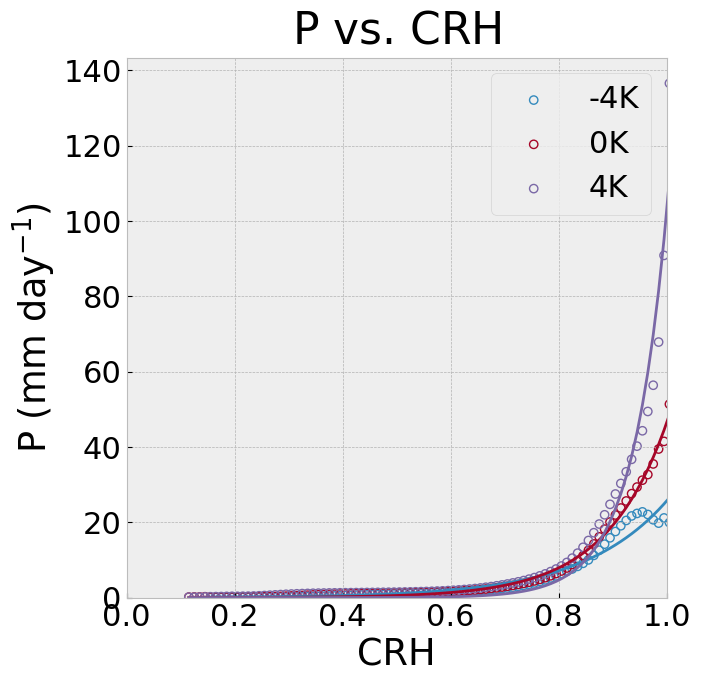

In [118]:
plt.rcParams["mathtext.default"] = 'regular'
plt.style.use('bmh')
plt.rcParams.update({'font.size':22})

fig = plt.figure(figsize=(9, 6))
gs = GridSpec(1, 1, figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95)

ax = fig.add_subplot(gs[0])

ax.set_title(r"$P$ vs. CRH", pad=10)
for index,experiment in enumerate(experiments_list):

    ax.scatter(
        variable_mean_over_CRH['Precipitation'].CRH,
        variable_mean_over_CRH['Precipitation'].sel(experiment=experiment),
        label=experiment,
        edgecolors=bmh_colors(index+1),
        facecolors='none',
        lw=1
    )

    plt.plot(
        variable_mean_over_CRH['Precipitation'].sel(experiment=experiment).dropna(dim='CRH').CRH,
        reference_precipitation.sel(experiment=experiment)*np.exp(
            reference_slope_parameter.sel(experiment=experiment)
            * variable_mean_over_CRH['Precipitation'].sel(experiment=experiment).dropna(dim='CRH').CRH
        )
    )

ax.set_ylabel(r'P (mm day$^{-1}$)')
ax.set_xlabel('CRH')
ax.set_ylim(bottom=0)
ax.set_xlim(0, 1)
ax.legend()

ratio = 1.0
xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

plt.show()

In [ ]:
near_equatorial_mean_precipitation = multi_experiment_variables_subset['Precipitation'].sel(lat=slice(-10,10)).mean(dim=['time', 'lat', 'lon'])
reference_CRH = {}

reference_CRH = np.abs(
    variable_mean_over_CRH['Precipitation']
    - near_equatorial_mean_precipitation
).idxmin('CRH')

climatological_mean_SSH = (100/9.8)*multi_experiment_variables_subset['Saturation Specific Humidity'].sel(
    plev=slice(100,950)
).integrate('plev').mean(dim=['time', 'lat', 'lon'])
tau_c = (
    climatological_mean_SSH
    / (reference_precipitation*reference_slope_parameter*np.exp(reference_slope_parameter*reference_CRH))
)

# EOF Analysis

In [72]:
missing_days.append(cftime.DatetimeNoLeap(7, 2, 4, 0, 0, 0, 0, has_year_zero=True))
# missing_days.append(cftime.DatetimeNoLeap(7, 2, 8, 0, 0, 0, 0, has_year_zero=True))

In [73]:
diabatic_heating_flattened = multi_experiment_variables_subset['Diabatic Heating'].sel(
    lat=slice(-15,15), plev=slice(100, 950)
).drop_sel(time=missing_days, errors='ignore').stack(
    tll = ("time", "lat", "lon")
)

time = multi_experiment_variables_subset['Diabatic Heating'].time.drop_sel(time=missing_days, errors='ignore')
latitude = multi_experiment_variables_subset['Diabatic Heating'].lat.sel(lat=slice(-15,15))
longitude = multi_experiment_variables_subset['Diabatic Heating'].lon
pressure_levels = multi_experiment_variables_subset['Diabatic Heating'].plev.sel(plev=slice(100,950))

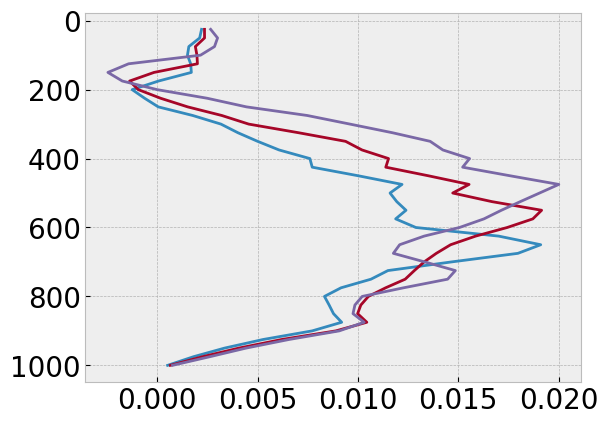

In [37]:
plt.style.use('bmh')
plt.figure()
for experiment in experiments_list:
    plt.plot(
        # experiment_mean_diabatic_heating.sel(experiment=experiment),
        experiment_mean_diabatic_heating.plev,
    )

plt.gca().invert_yaxis()
plt.show()

In [115]:
print(f"{f'EOF Analysis':^{str_width}}")
print(f"{'='*str_width}")

EOF = xr.DataArray(
    data = np.empty((
        len(experiments_list),
        len(pressure_levels),
        len(pressure_levels)
    )),
    dims=["experiment", "index", "plev"],
    coords=dict(
        experiment=experiments_list,
        index=np.arange(1, len(pressure_levels)+1),
        plev=pressure_levels
    )
)

PC = xr.DataArray(
    data = np.empty((
        len(experiments_list),
        len(pressure_levels),
        len(time),
        len(latitude),
        len(longitude)
    )),
    dims=["experiment", "index", "time", "lat", "lon"],
    coords=dict(
        experiment=experiments_list,
        index=np.arange(1, len(pressure_levels)+1),
        time=time,
        lat=latitude,
        lon=longitude
    )
)

eigenvalue_spectrum = xr.DataArray(
    data = np.empty((len(experiments_list), len(pressure_levels))),
    dims=["experiment", "index"],
    coords=dict(
        experiment=experiments_list,
        index=np.arange(1, len(pressure_levels)+1),
    )
)

spectrum_error = xr.DataArray(
    data = np.empty((len(experiments_list), len(pressure_levels))),
    dims=["experiment", "index"],
    coords=dict(
        experiment=experiments_list,
        index=np.arange(1, len(pressure_levels)+1),
    )
)

#### Calculate EOFs and PCs
for experiment_index, experiment in enumerate(experiments_list):
    print(f"{f'Experiment: {experiment}...':<{str_width-1}}")
    print(f"{'    Computing EOFs and PCs...':<{str_width-1}}", end="")
    U, S, VT = np.linalg.svd(diabatic_heating_flattened.sel(experiment=experiment).values, full_matrices=False)
    EOF[experiment_index][:] = U.T
    PC[experiment_index][:] = np.reshape(
        np.dot(np.diag(S), VT),
        (
            len(pressure_levels),
            len(time),
            len(latitude),
            len(longitude)
        )
    )
    print(rf"{'✔':>1}")

    # Calculate nominal degrees of freedom
    print(f"{'    Estimating DoF...':<{str_width-1}}", end="")
    nominal_degrees_of_freedom = np.size(diabatic_heating_flattened.sel(experiment=experiment), 1)
    print(rf"{'✔':>1}")

    # Calculate eigenvalues and spectrum
    print(f"{'    Calculating eigenvalues...':<{str_width-1}}", end="")
    eigenvalues = S**2 / nominal_degrees_of_freedom
    eigenvalue_spectrum[experiment_index][:] = eigenvalues / np.sum(eigenvalues)
    explained_variance = 100*eigenvalue_spectrum
    print(rf"{'✔':>1}")

    # print(f"{'    Calculating spectrum error...':<{str_width-1}}", end="")
    # # Estimate 1-lag autocorrelation and effective degrees of freedom
    # lag = 1
    # B = 0
    # for k in range(lag - 1, nominal_degrees_of_freedom - lag):
    #     B = B + np.sum(diabatic_heating_flattened.sel(experiment=experiment)[:, k] * diabatic_heating_flattened.sel(experiment=experiment)[:, k + lag])
    # phi_L = 1 / (nominal_degrees_of_freedom - 2 * lag) * B
    # phi_0 = 1 / nominal_degrees_of_freedom * np.sum(diabatic_heating_flattened.sel(experiment=experiment) ** 2)
    # autocorrelation = phi_L / phi_0
    # degrees_of_freedom = ((1 - autocorrelation ** 2) / (1 + autocorrelation ** 2))*nominal_degrees_of_freedom

    # # Estimate uncertainty in eigenvalue spectrum
    # spectrum_error[experiment_index][:] = eigenvalue_spectrum[experiment_index] * np.sqrt(2 / degrees_of_freedom)
    # print(rf"{'✔':>1}")

print(f"{'='*str_width}")
print("Finished")

              EOF Analysis              
Experiment: -4K...                     
    Computing EOFs and PCs...          ✔
    Estimating DoF...                  ✔
    Calculating eigenvalues...         ✔
✔
Experiment: 0K...                      
    Computing EOFs and PCs...          ✔
    Estimating DoF...                  ✔
    Calculating eigenvalues...         ✔
✔
Experiment: 4K...                      
    Computing EOFs and PCs...          ✔
    Estimating DoF...                  ✔
    Calculating eigenvalues...         ✔
✔
Finished


In [116]:
rescaled_EOF = EOF.copy(deep=True)
for experiment_index, experiment in enumerate(experiments_list):
    rescaled_EOF[experiment_index] *= np.sign(EOF.sel(experiment=experiment).isel(plev=-1))
    rescaled_EOF[experiment_index] *= PC.sel(experiment=experiment).std(dim=['time', 'lat', 'lon'])

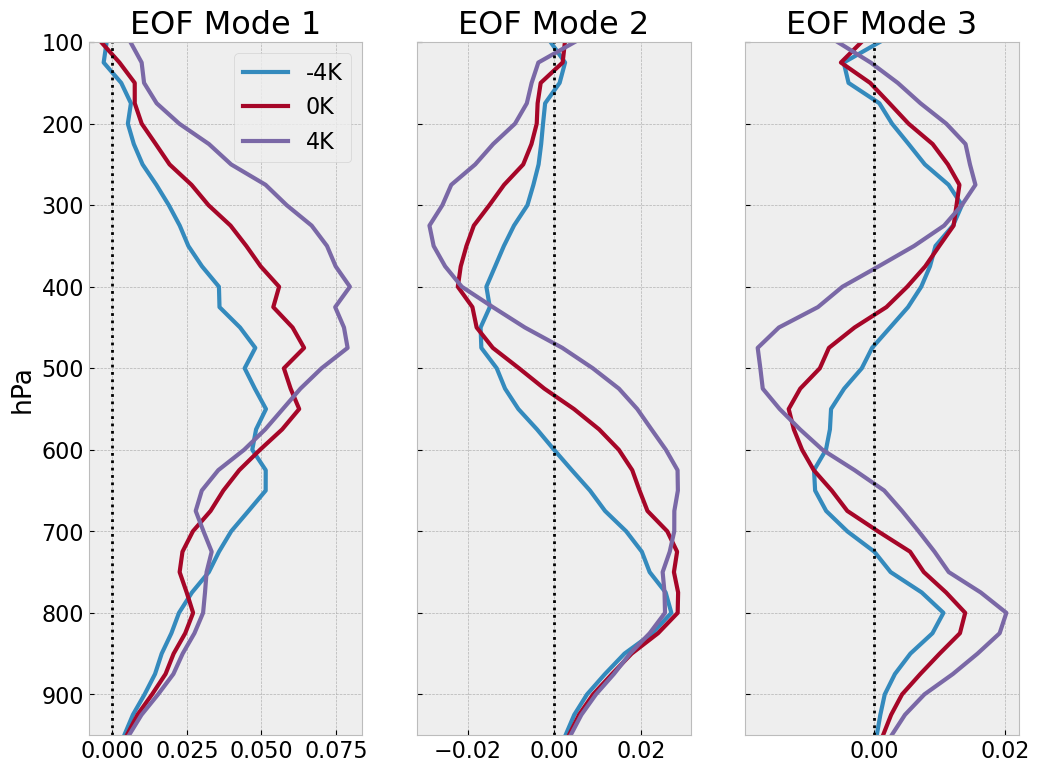

In [118]:
plt.style.use('bmh')
plt.rcParams.update(
    {
        'font.size':16,
        'mathtext.fontset':'dejavusans'
    }
)


[fig, ax] = plt.subplots(1, 3, figsize=(12,9))
for eof_index in range(1, 4):
    ax[eof_index-1].set_title(f'EOF Mode {eof_index}')
    for experiment in experiments_list:
        ax[eof_index-1].plot(
            rescaled_EOF.sel(experiment=experiment, index=eof_index),
            rescaled_EOF.plev,
            # label=f"EOF {index+1}: {100*eigenvalue_spectrum[index]:0.1f}%",
            label=experiment,
            lw=3
        )
    ax[eof_index-1].axvline(x=0, ls=':', color='k')

for axis_index, axis in enumerate(ax):
    # axis.set_xlim(-0.5, 0.5)
    # axis.set_xticks(np.arange(-0.5, 0.75, 0.25))
    axis.set_ylim(100, 950)
    if axis_index == 0:
        axis.set_yticks(np.arange(100, 950, 100))
        axis.set_ylabel('hPa')
        axis.legend(loc='upper right', fontsize=16)
    else:
        axis.set_yticks(np.arange(100, 950, 100), labels=[])
    axis.invert_yaxis()
plt.show()

In [119]:
estimated_precipitation = (
    (1/LIQUID_WATER_DENSITY)
    * (1/HEAT_OF_VAPORIZATION)
    * (1000*SECONDS_PER_DAY)
    * (100/9.8)*(rescaled_EOF.sel(index=1)*alpha_by_CRH).sel(plev=slice(100,950)).integrate('plev')
)

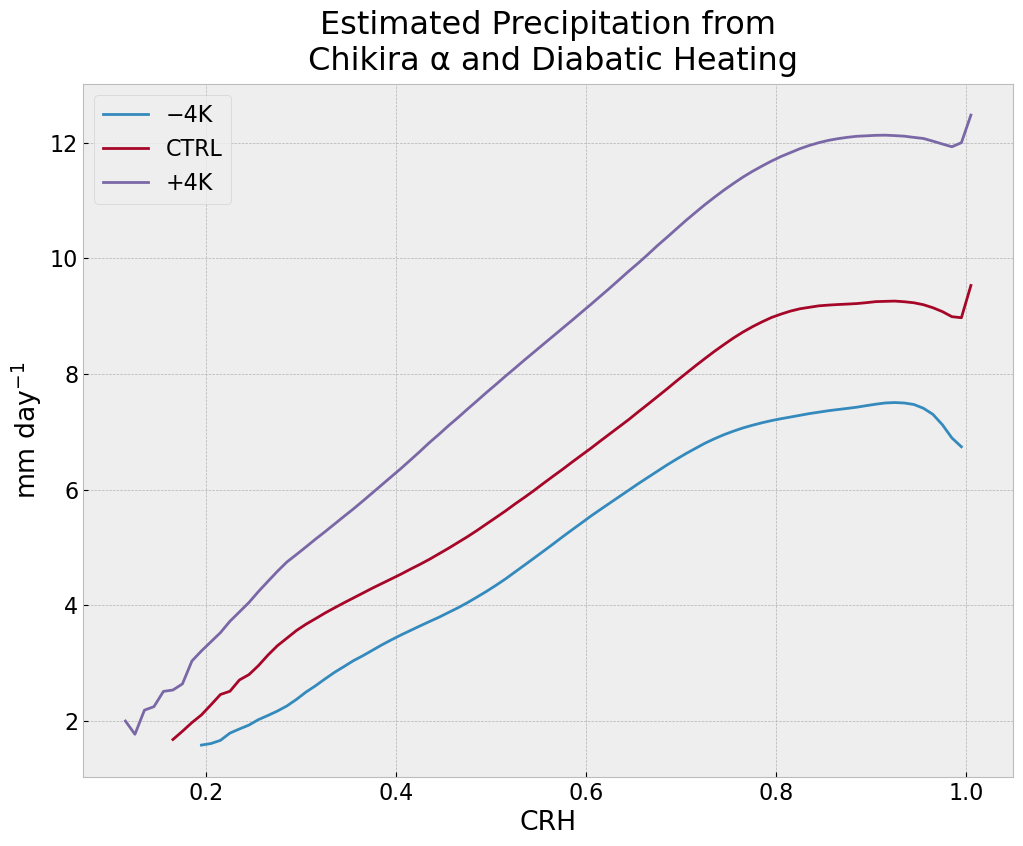

In [127]:
[fig, ax] = plt.subplots(1, 1, figsize=(12,9))
ax.set_title("Estimated Precipitation from\n Chikira α and Diabatic Heating", pad=10)
for experiment in experiments_list:
    ax.plot(
        estimated_precipitation.CRH,
        estimated_precipitation.sel(experiment=experiment),
        label=experiments_array.sel(experiment=experiment)['name'].item()
    )

ax.scatter(
        variable_mean_over_CRH['Precipitation'].CRH,
        variable_mean_over_CRH['Precipitation'].sel(experiment=experiment),
        label=experiment,
        edgecolors=bmh_colors(index+1),
        facecolors='none',
        lw=1
    )

ax.set_ylabel(r"mm day$^{-1}$")
ax.set_xlabel("CRH")
ax.legend()
plt.show()

In [ ]:
savefig = False
# variable_to_plot = 'alpha'

variable_mean_over_CRH['Chikira alpha'] = alpha_by_CRH
variable_mean_over_CRH['Moisture'].name = 'Moisture'
variable_mean_over_CRH['Moisture'].attrs = multi_experiment_variables_subset['Moisture'].attrs
variable_mean_over_CRH['Potential Temperature'].attrs = multi_experiment_variables_subset['Potential Temperature'].attrs

scaled_moisture = 0.01*(HEAT_OF_VAPORIZATION/SPECIFIC_HEAT)*variable_mean_over_CRH['Moisture'].differentiate('plev')
scaled_moisture.attrs = variable_mean_over_CRH['Moisture'].attrs
scaled_moisture.attrs['units'] = 'K/hPa'

scaled_potential_temperature = 0.01*(variable_mean_over_CRH['Potential Temperature']*exner_function).differentiate('plev')
scaled_potential_temperature.attrs = variable_mean_over_CRH['Potential Temperature'].attrs
scaled_potential_temperature.attrs['units'] = 'K/hPa'

variables_to_plot = [
    variable_mean_over_CRH['alpha'],
    scaled_moisture,
    scaled_potential_temperature
]

colorbar_bounds = [
    np.arange(0, 3.1, 0.1),
    np.linspace(0, 0.003, 21),
    np.linspace(0, 0.003, 21),
]
plt.rcParams.update({'font.size':20, 'mathtext.fontset':'dejavusans'})

fig = plt.figure(figsize=(20,16))

gs = GridSpec(3, 4, figure=fig, width_ratios = [20, 20, 20, 1])
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, wspace=0.2, hspace=0.3)

for row_index, variable_data in enumerate(variables_to_plot):

    axes = []
    grand_min = variable_mean_over_CRH[variable_to_plot].min()
    grand_max = variable_mean_over_CRH[variable_to_plot].max()

    cbar_ax = fig.add_subplot(gs[row_index, -1])

    for column_index, experiment in enumerate(experiments_list):
        axes.append(fig.add_subplot(gs[row_index, column_index]))
        axes[column_index].set_title(experiments_array.sel(experiment=experiment)['name'].item(), fontsize=24, pad=10)
        im = axes[column_index].contourf(
            variable_data.CRH,
            variable_data.plev,
            variable_data.sel(experiment=experiment).T,
            # levels=np.arange(0, 3+0.1, 0.1),
            levels=colorbar_bounds[row_index],
            cmap=(mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05) if variable_data.name == 'Chikira alpha' else 'viridis'),
            norm=(mcolors.CenteredNorm(vcenter=1) if variable_data.name == 'Chikira alpha' else mcolors.Normalize()),
            extend=('max' if variable_data.name == 'Chikira alpha' else 'both')
        )
        # axes[index].yaxis.grid()
        axes[column_index].grid(True, ls=':')

        ax2 = plt.twinx()
        ax2.scatter(
            variable_mean_over_CRH['Precipitation'].CRH,
            variable_mean_over_CRH['Precipitation'].sel(experiment=experiment),
            label=experiment,
            # edgecolors=bmh_colors(index+1),
            edgecolors='k',
            facecolors='none',
            lw=1,
        )
        ax2.set_ylim(0, 100)
        ax2.set_yticks(np.arange(10,110,10))
        ax2.grid(False)
        # ax2.set_ylabel(r'mm day$^{-1}$')

    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label(variable_data.attrs['units'])
    # cbar.set_ticks(np.arange(0, 3.25, 0.25))

    # fig.suptitle(
    #     f"Mean-state {variable_data.attrs['short_name']} binned by CRH",
    #     x=(axes[0].get_position().x0 + axes[-1].get_position().x1)/2,
    #     ha='center',
    #     y=1.075,
    #     size=28
    # )

    for index, ax in enumerate(axes):

        ax.set_facecolor('lightgrey')
        for edge in ["top", "bottom", "left", "right"]:
            ax.spines[edge].set_linewidth(2)
            ax.spines[edge].set_color("#bcbcbc")
        ax.set_xlabel('CRH')
        ax.set_xlim(0.2, 1)
        ax.set_xticks(np.arange(0.2, 1.2, 0.2))
        # ax.xaxis.set_major_locator(mticker.MaxNLocator(6, prune="lower"))
        if index == 0:
            ax.set_ylabel('hPa')
            ax.set_yticks(np.arange(100, 1100, 100))
        else:
            ax.set_yticks(np.arange(100, 1100, 100), labels=[])
        ax.set_ylim(100, 950)
        ax.invert_yaxis()

if not savefig:
    plt.show()
else:
    save_string = (
        f"multi-experiment_{variable_mean_over_CRH[variable_to_plot].attrs['file_id']}.png"
        )
    print(f"Saving plot as {save_string}")
    plt.savefig(
        f"{output_directory}/mean-state/variables_binned_by_CRH/{save_string}",
        dpi=500,
        bbox_inches="tight",
    )

# print(f"{'='*str_width}")
# print("Finished")